# Deep Hedging Environment
The following is the code for a deep hedging environment that is able to hedge delta, gamma, and vega using a basic LSTM RL neural network


# GARCH Simulation
This Block implements vectorized Heston-Nandi option pricing. Key elements:

Precomputation: Coefficients in the characteristic function that depend only on model parameters (not on spot S, strike K, or variance) are precomputed. This includes time-recursive terms and quadrature nodes/weights.

Purpose: Significantly reduces computation when pricing many options or computing deltas repeatedly, as only market-dependent values are processed in the main functions.

Functions:

precompute_hn_coefficients: computes and stores coefficients for all time steps and quadrature nodes.

price_option_precomputed: prices options using the precomputed coefficients.

delta_precomputed_analytical: computes delta analytically using the precomputed coefficients.
gamma_precomputed_analytical: computes gamma analytically using the precomputed coefficients.
vega_precomputed_analytical: computes vega analytically using the precomputed coefficients.
Context: Precomputation leverages fixed GARCH parameters (from S&P 500 options on October 1st) to speed up training in a hedging environment.

# Heston-Nandi Pricing Functions Overview

### Scalar function
Computes the real part of the Heston-Nandi characteristic function for a single option.  
- Recursively computes the `a` and `b` coefficients over time.  
- Inputs: spot `S`, strike `X`, time to maturity, risk-free rate `r_daily`, GARCH parameters.  
- Output: single float — the real part of the Fourier integrand.

### Vectorized version
Applies the scalar function across multiple options in parallel.  
- Inputs: flattened arrays of `S`, `X`, `Time`, and `r_daily`.  
- Output: 1D numpy array of real values, one per option.  
- Uses Numba `prange` for parallel computation.

### Complex scalar
Computes the full complex characteristic function for a single option.  
- Same recursion as scalar version but keeps complex values.  
- Used for full Fourier integration needed in option pricing or delta calculation.

### Vectorized complex
Applies the complex scalar function across multiple options in parallel.  
- Inputs: flattened arrays of `S`, `X`, `Time`, and `r_daily`.  
- Output: 1D numpy array of `complex128` values.  
- Optimized with Numba parallel loops for batch computation.


In [ ]:
# --------------------------------------------------------------------------
# Precomputation Functions
# --------------------------------------------------------------------------
def precompute_hn_coefficients(N, r_daily, omega, alpha, beta, gamma, lambda_,
                                N_quad=128, u_max=100.0, device="cpu"):
    """
    Precompute Heston-Nandi characteristic function coefficients - VECTORIZED.
    """
    device_t = torch.device(device)
    u_nodes, w_nodes = leggauss(N_quad)
    u_nodes = 0.5 * (u_nodes + 1) * u_max
    w_nodes = 0.5 * u_max * w_nodes

    u_nodes_t = torch.tensor(u_nodes, dtype=torch.float64, device=device_t)
    w_nodes_t = torch.tensor(w_nodes, dtype=torch.float64, device=device_t)

    omega_c = torch.tensor(omega, dtype=torch.complex128, device=device_t)
    alpha_c = torch.tensor(alpha, dtype=torch.complex128, device=device_t)
    beta_c = torch.tensor(beta, dtype=torch.complex128, device=device_t)
    gamma_c = torch.tensor(gamma, dtype=torch.complex128, device=device_t)
    lambda_c = torch.tensor(lambda_, dtype=torch.complex128, device=device_t)
    r_daily_c = torch.tensor(r_daily, dtype=torch.complex128, device=device_t)

    coefficients = torch.zeros((N+1, N_quad, 2, 3), dtype=torch.complex128, device=device_t)

    lambda_r = torch.tensor(-0.5, dtype=torch.complex128, device=device_t)
    gamma_r = gamma_c + lambda_c + 0.5
    denom_sigma = 1.0 - beta_c - alpha_c * gamma_r**2
    sigma2 = (omega_c + alpha_c) / denom_sigma

    # Vectorize over quadrature nodes
    u_vec = torch.tensor(u_nodes, dtype=torch.complex128, device=device_t)
    cphi0_vec = 1j * u_vec  # [N_quad]

    for n in range(N+1):
        Time_inDays = N - n

        # Process const=1.0 and const=0.0 separately but vectorize over N_quad
        for const_idx, const_val in enumerate([1.0, 0.0]):
            const_c = torch.tensor(const_val, dtype=torch.complex128, device=device_t)
            cphi_vec = cphi0_vec + const_c  # [N_quad]

            # Initialize for all quadrature nodes at once
            a_vec = cphi_vec * r_daily_c  # [N_quad]
            b_vec = lambda_r * cphi_vec + 0.5 * cphi_vec**2  # [N_quad]

            # Recursive calculation vectorized over N_quad
            for i in range(1, Time_inDays):
                denom_vec = 1.0 - 2.0 * alpha_c * b_vec
                a_vec = a_vec + cphi_vec * r_daily_c + b_vec * omega_c - 0.5 * torch.log(denom_vec)
                b_vec = (cphi_vec * (lambda_r + gamma_r) - 0.5 * gamma_r**2 +
                         beta_c * b_vec + 0.5 * (cphi_vec - gamma_r)**2 / denom_vec)

            # Store results
            coefficients[n, :, const_idx, 0] = -cphi0_vec
            coefficients[n, :, const_idx, 1] = cphi_vec
            coefficients[n, :, const_idx, 2] = a_vec + b_vec * sigma2

    return {
        "coefficients": coefficients,
        "u_nodes": u_nodes_t,
        "w_nodes": w_nodes_t,
        "N": N,
        "r_daily": r_daily,
        "device": device
    }


def price_option_precomputed(S, K, step_idx, r_daily, N, option_type, precomputed_data):
    """
    Price option using precomputed coefficients.
    """
    device = torch.device(precomputed_data["device"])
    coefficients = precomputed_data["coefficients"]
    u_nodes = precomputed_data["u_nodes"]
    w_nodes = precomputed_data["w_nodes"]

    # Convert to float64 for precision
    S_t = torch.as_tensor(S, dtype=torch.float64, device=device)
    K_t = torch.as_tensor(K, dtype=torch.float64, device=device)

    shape = torch.broadcast_shapes(S_t.shape, K_t.shape)
    S_bc = S_t.expand(shape) if S_t.shape != shape else S_t
    K_bc = K_t.expand(shape) if K_t.shape != shape else K_t

    log_S = torch.log(S_bc)
    log_K = torch.log(K_bc)

    # Get precomputed coefficients: [N_quad, 2, 3]
    coeff_step = coefficients[step_idx]

    # Compute characteristic functions for const=1
    coeff_K_1 = coeff_step[:, 0, 0]
    coeff_S_1 = coeff_step[:, 0, 1]
    const_term_1 = coeff_step[:, 0, 2]

    exponent_1 = (coeff_K_1.unsqueeze(-1) * log_K.unsqueeze(0) +
                  coeff_S_1.unsqueeze(-1) * log_S.unsqueeze(0) +
                  const_term_1.unsqueeze(-1))

    cphi0_1 = 1j * u_nodes
    f1 = torch.exp(exponent_1) / cphi0_1.unsqueeze(-1) / np.pi

    # Compute characteristic functions for const=0
    coeff_K_0 = coeff_step[:, 1, 0]
    coeff_S_0 = coeff_step[:, 1, 1]
    const_term_0 = coeff_step[:, 1, 2]

    exponent_0 = (coeff_K_0.unsqueeze(-1) * log_K.unsqueeze(0) +
                  coeff_S_0.unsqueeze(-1) * log_S.unsqueeze(0) +
                  const_term_0.unsqueeze(-1))

    cphi0_0 = 1j * u_nodes
    f0 = torch.exp(exponent_0) / cphi0_0.unsqueeze(-1) / np.pi

    # Compute integrands
    integrand1 = torch.real(f1)
    integrand2 = torch.real(f0)

    # Integrate
    call1 = torch.sum(w_nodes.unsqueeze(-1) * integrand1, dim=0)
    call2 = torch.sum(w_nodes.unsqueeze(-1) * integrand2, dim=0)

    # Discount factor
    Time_inDays = float(N - step_idx)
    disc = torch.exp(torch.tensor(-r_daily * Time_inDays, dtype=torch.float64, device=device))

    # Heston-Nandi pricing formula
    call_price = S_bc * 0.5 + disc * call1 - K_bc * disc * (0.5 + call2)

    if option_type == "call":
        return call_price.to(torch.float32)
    elif option_type == "put":
        return (call_price - S_bc + K_bc * disc).to(torch.float32)
    else:
        raise ValueError("option_type must be 'call' or 'put'")


def delta_precomputed_analytical(S, K, step_idx, r_daily, N, option_type, precomputed_data):
    """
    Compute delta analytically using precomputed coefficients.
    Delta = d(Price)/dS using the characteristic function formula directly.
    """
    device = torch.device(precomputed_data["device"])
    coefficients = precomputed_data["coefficients"]
    u_nodes = precomputed_data["u_nodes"]
    w_nodes = precomputed_data["w_nodes"]

    S_t = torch.as_tensor(S, dtype=torch.float64, device=device)
    K_t = torch.as_tensor(K, dtype=torch.float64, device=device)

    shape = torch.broadcast_shapes(S_t.shape, K_t.shape)
    S_bc = S_t.expand(shape) if S_t.shape != shape else S_t
    K_bc = K_t.expand(shape) if K_t.shape != shape else K_t

    log_S = torch.log(S_bc)
    log_K = torch.log(K_bc)

    coeff_step = coefficients[step_idx]

    # For const=1
    coeff_K_1 = coeff_step[:, 0, 0]
    coeff_S_1 = coeff_step[:, 0, 1]
    const_term_1 = coeff_step[:, 0, 2]

    exponent_1 = (coeff_K_1.unsqueeze(-1) * log_K.unsqueeze(0) +
                  coeff_S_1.unsqueeze(-1) * log_S.unsqueeze(0) +
                  const_term_1.unsqueeze(-1))

    cphi0_1 = 1j * u_nodes
    f1 = torch.exp(exponent_1) / cphi0_1.unsqueeze(-1) / np.pi

    # Derivative: d/dS of exp(...) = exp(...) * coeff_S / S
    df1_dS = f1 * coeff_S_1.unsqueeze(-1) / S_bc.unsqueeze(0)

    # For const=0
    coeff_K_0 = coeff_step[:, 1, 0]
    coeff_S_0 = coeff_step[:, 1, 1]
    const_term_0 = coeff_step[:, 1, 2]

    exponent_0 = (coeff_K_0.unsqueeze(-1) * log_K.unsqueeze(0) +
                  coeff_S_0.unsqueeze(-1) * log_S.unsqueeze(0) +
                  const_term_0.unsqueeze(-1))

    cphi0_0 = 1j * u_nodes
    f0 = torch.exp(exponent_0) / cphi0_0.unsqueeze(-1) / np.pi

    df0_dS = f0 * coeff_S_0.unsqueeze(-1) / S_bc.unsqueeze(0)

    # Integrate derivatives
    delta1 = torch.sum(w_nodes.unsqueeze(-1) * torch.real(df1_dS), dim=0)
    delta2 = torch.sum(w_nodes.unsqueeze(-1) * torch.real(df0_dS), dim=0)

    Time_inDays = float(N - step_idx)
    disc = torch.exp(torch.tensor(-r_daily * Time_inDays, dtype=torch.float64, device=device))

    # Delta formula: dC/dS = 0.5 + disc * delta1 - K * disc * delta2
    delta_call = 0.5 + disc * delta1 - K_bc * disc * delta2

    if option_type == "call":
        return delta_call.to(torch.float32)
    elif option_type == "put":
        return (delta_call - 1.0).to(torch.float32)
    else:
        raise ValueError("option_type must be 'call' or 'put'")


In [ ]:


%%writefile hn_utils.py
import numpy as np
from numba import jit, prange

# -------------------------------
# Scalar function
@jit(nopython=True, cache=True)
def _fstar_hn_scalar(phi, const, S, X, Time_inDays, r_daily, omega, alpha, beta, gamma, lambda_):
    cphi0 = 1j * phi
    cphi = cphi0 + const
    lambda_r = -0.5
    gamma_r = gamma + lambda_ + 0.5
    sigma2 = (omega + alpha) / (1 - beta - alpha * gamma_r**2)

    a = cphi * r_daily
    b = lambda_r * cphi + 0.5 * cphi**2

    for i in range(1, int(Time_inDays)):
        denom = 1 - 2 * alpha * b
        a = a + cphi * r_daily + b * omega - 0.5 * np.log(denom)
        b = cphi * (lambda_r + gamma_r) - 0.5 * gamma_r**2 + beta * b + 0.5 * (cphi - gamma_r)**2 / denom

    result = np.exp(-cphi0 * np.log(X) + cphi * np.log(S) + a + b * sigma2) / cphi0 / np.pi
    return result.real

# -------------------------------
# Vectorized version
@jit(nopython=True, parallel=True, cache=True)
def _fstar_hn_vectorized(phi, const, S_flat, X_flat, Time_flat, r_flat, omega, alpha, beta, gamma, lambda_, n_elements):
    result = np.empty(n_elements, dtype=np.float64)
    for idx in prange(n_elements):
        result[idx] = _fstar_hn_scalar(phi, const, S_flat[idx], X_flat[idx], Time_flat[idx], r_flat[idx], omega, alpha, beta, gamma, lambda_)
    return result

# -------------------------------
# Complex scalar
@jit(nopython=True, cache=True)
def _f_hn_scalar(phi, const, S, X, Time_inDays, r_daily, omega, alpha, beta, gamma, lambda_):
    cphi0 = 1j * phi
    cphi = cphi0 + const
    lambda_r = -0.5
    gamma_r = gamma + lambda_ + 0.5
    sigma2 = (omega + alpha) / (1 - beta - alpha * gamma_r**2)

    a = cphi * r_daily
    b = lambda_r * cphi + 0.5 * cphi**2

    for i in range(1, int(Time_inDays)):
        denom = 1 - 2 * alpha * b
        a = a + cphi * r_daily + b * omega - 0.5 * np.log(denom)
        b = cphi * (lambda_r + gamma_r) - 0.5 * gamma_r**2 + beta * b + 0.5 * (cphi - gamma_r)**2 / denom

    return np.exp(-cphi0 * np.log(X) + cphi * np.log(S) + a + b * sigma2) / cphi0 / np.pi

# -------------------------------
# Vectorized complex
@jit(nopython=True, parallel=True, cache=True)
def _f_hn_vectorized(phi, const, S_flat, X_flat, Time_flat, r_flat, omega, alpha, beta, gamma, lambda_, n_elements):
    result = np.empty(n_elements, dtype=np.complex128)
    for idx in prange(n_elements):
        result[idx] = _f_hn_scalar(phi, const, S_flat[idx], X_flat[idx], Time_flat[idx], r_flat[idx], omega, alpha, beta, gamma, lambda_)
    return result

Overwriting hn_utils.py


# No RL Hedging Environment Class
### The following class utilizes GBM to simulate hedging procedures under varying time grids and helps to easily visualize terminal error distributions, incremental P&L changes, and variance differences across timesteps or at the last timestep. Included in this class are functions that assume non-uniform time grids, specifically utilizing the bucket chunking method.
### The 'unequal_run()' method references this procedure and allows you to specify proportions, an array of hedge frequencies for a time bucket, and chunks, the number of time buckets. Conversely, the 'equal_run()' method assumes that the time interval hedges is constant and it is set at 1/N years.


In [ ]:
import numpy as np
from scipy.stats import norm, skew, kurtosis
import matplotlib.pyplot as plt
from scipy.special import softmax
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from math import lcm
import numpy as np
import warnings
from scipy.integrate import quad
import numpy as np
from numpy import exp, log, real
from numpy.polynomial.legendre import leggauss
from typing import Optional
from numba import njit



import numpy as np
from numba import jit, prange
from numpy.polynomial.legendre import leggauss
from scipy.stats import norm
import sys
sys.path.append('/content')  # add current folder to Python path just in case

# Step 2: Import the module
import hn_utils
import importlib
importlib.reload(hn_utils)  # reload if you edited it

# Step 3: Import the functions
from hn_utils import _fstar_hn_scalar, _fstar_hn_vectorized, _f_hn_scalar, _f_hn_vectorized

# Test

class HedgingSim:
    """
    Delta hedging for European call/put under Black-Scholes with proportional transaction costs.
    side = +1 short option, -1 long option.
    Stored D = unsigned delta * contract_size.
    Signed share position each step = side * D.
    Re-hedge trade (shares) = side * (newD - oldD).
    Final P&L = -side * payoff + B_T + side * D_T * S_T
    """

    def __init__(self, S0, K, m, r, sigma, T, option_type="call", position="long",
                M=5000, N=252, TCP=0.0001, contract_size=1, seed=42):
        self.S0 = S0
        self.K = K
        self.m = m
        self.r = r
        self.sigma = sigma        # initial annualized volatility
        self.T = T
        self.option_type = option_type.lower()
        self.position = position.lower()
        self.M = M
        self.N = N
        self.TCP = TCP
        self.contract_size = contract_size
        self.seed = seed
        self.dt = T / N
        self.side = 1 if self.position == "short" else -1
        if seed is not None:
            np.random.seed(seed)

        # -----------------------
        # GARCH(1,1) parameters
        # -----------------------
        self.omega = 1.593749e-07    # long-run variance component
        self.alpha = 2.308475e-06     # reaction to new shocks
        self.beta  =0.689984      # persistence
        self.gamma = 342.870019      # leverage effect (set 0 if unused)
        self.lambda_ = .420499
        self.sigma0 = sigma   # starting vol level

    def bs_price(self, S, K, T, r, sigma, option_type="call",  # basic black scholes function
                 q=0.0, intrinsic_at_expiry=True, min_time=1e-12, min_vol=1e-12):
        S = np.asarray(S, float); K = np.asarray(K, float)
        T = np.asarray(T, float); sigma = np.asarray(sigma, float)
        S, K, T, sigma = np.broadcast_arrays(S, K, T, sigma)
        out = np.empty_like(S)
        exp_mask = T <= min_time
        live_mask = ~exp_mask
        if np.any(exp_mask):
            call_intr = np.maximum(S[exp_mask] - K[exp_mask], 0.0)
            put_intr = np.maximum(K[exp_mask] - S[exp_mask], 0.0)
            if intrinsic_at_expiry:
                if option_type == "call":
                    out[exp_mask] = call_intr
                elif option_type == "put":
                    out[exp_mask] = put_intr
                else:
                    raise ValueError("option_type must be 'call' or 'put'")
            else:
                live_mask = np.ones_like(T, bool)
                exp_mask[:] = False
        if np.any(live_mask):
            T_eff = np.maximum(T[live_mask], min_time)
            sig_eff = np.maximum(sigma[live_mask], min_vol)
            sqrtT = np.sqrt(T_eff)
            d1 = (np.log(S[live_mask] / K[live_mask]) + (r - q + 0.5*sig_eff**2)*T_eff) / (sig_eff*sqrtT)
            d2 = d1 - sig_eff*sqrtT
            disc_r = np.exp(-r*T_eff); disc_q = np.exp(-q*T_eff)
            if option_type == "call":
                val = S[live_mask]*disc_q*norm.cdf(d1) - K[live_mask]*disc_r*norm.cdf(d2)
            else:
                val = K[live_mask]*disc_r*norm.cdf(-d2) - S[live_mask]*disc_q*norm.cdf(-d1)
            out[live_mask] = val
        return float(out) if out.shape == () else out


    def bs_delta(self, S, K, T, r, sigma, option_type="call", q=0.0, min_time=1e-12, min_vol=1e-12):
        """
        Vectorized Black-Scholes delta calculation.

        Parameters:
        -----------
        S : array_like
            Spot price(s)
        K : array_like
            Strike price(s)
        T : array_like
            Time to expiration (years)
        r : float
            Risk-free rate
        sigma : array_like
            Volatility
        option_type : str
            'call' or 'put'
        q : float
            Dividend yield (default 0.0)
        min_time : float
            Minimum time threshold (default 1e-12)
        min_vol : float
            Minimum volatility threshold (default 1e-12)

        Returns:
        --------
        float or ndarray
            Delta value(s)
        """
        # Convert to arrays and broadcast
        S, K, T, sigma = np.broadcast_arrays(
            np.asarray(S, float),
            np.asarray(K, float),
            np.asarray(T, float),
            np.asarray(sigma, float)
        )

        # Initialize output
        delta = np.zeros_like(S)

        # Handle expired options
        exp_mask = T <= min_time
        if np.any(exp_mask):
            if option_type == "call":
                delta[exp_mask] = (S[exp_mask] > K[exp_mask]).astype(float)
            else:
                delta[exp_mask] = -(S[exp_mask] < K[exp_mask]).astype(float)

        # Handle live options
        live_mask = ~exp_mask
        if np.any(live_mask):
            T_live = np.maximum(T[live_mask], min_time)
            sig_live = np.maximum(sigma[live_mask], min_vol)

            # Calculate d1
            d1 = (np.log(S[live_mask] / K[live_mask]) +
                  (r - q + 0.5 * sig_live**2) * T_live) / (sig_live * np.sqrt(T_live))

            # Calculate delta based on option type
            discount = np.exp(-q * T_live)
            if option_type == "call":
                delta[live_mask] = discount * norm.cdf(d1)
            else:
                delta[live_mask] = discount * (norm.cdf(d1) - 1.0)

        # Return scalar if input was scalar
        return float(delta) if delta.shape == () else delta


    def fstar_hn(self, phi, const, S, X, Time_inDays, r_daily, omega, alpha, beta, gamma, lambda_):
        S = np.atleast_1d(S)
        X = np.atleast_1d(X)
        Time_inDays = np.atleast_1d(Time_inDays)
        r_daily = np.atleast_1d(r_daily)

        shape = np.broadcast_shapes(S.shape, X.shape, Time_inDays.shape, r_daily.shape)
        S_bc = np.broadcast_to(S, shape)
        X_bc = np.broadcast_to(X, shape)
        Time_bc = np.broadcast_to(Time_inDays, shape)
        r_bc = np.broadcast_to(r_daily, shape)

        n_elements = int(np.prod(shape))  # CAST TO PYTHON INT
        S_flat = S_bc.flatten()
        X_flat = X_bc.flatten()
        Time_flat = Time_bc.flatten()
        r_flat = r_bc.flatten()

        result_flat = _fstar_hn_vectorized(phi, const, S_flat, X_flat, Time_flat, r_flat, omega, alpha, beta, gamma, lambda_, n_elements)
        result = result_flat.reshape(shape)

        return float(result) if result.shape == () else result

    def f_hn(self, phi, const, S, X, Time_inDays, r_daily, omega, alpha, beta, gamma, lambda_):
        S = np.atleast_1d(S)
        X = np.atleast_1d(X)
        Time_inDays = np.atleast_1d(Time_inDays)
        r_daily = np.atleast_1d(r_daily)

        shape = np.broadcast_shapes(S.shape, X.shape, Time_inDays.shape, r_daily.shape)
        S_bc = np.broadcast_to(S, shape)
        X_bc = np.broadcast_to(X, shape)
        Time_bc = np.broadcast_to(Time_inDays, shape)
        r_bc = np.broadcast_to(r_daily, shape)

        n_elements = int(np.prod(shape))  # CAST TO PYTHON INT
        S_flat = S_bc.flatten()
        X_flat = X_bc.flatten()
        Time_flat = Time_bc.flatten()
        r_flat = r_bc.flatten()

        result_flat = _f_hn_vectorized(phi, const, S_flat, X_flat, Time_flat, r_flat, omega, alpha, beta, gamma, lambda_, n_elements)
        result = result_flat.reshape(shape)

        return result if result.shape != () else result.item()

    def hn_price(self, S, X, Time_inDays, r_daily, omega, alpha, beta, gamma, lambda_, option_type="call", N_quad=128, u_max=100.0):
        u_nodes, w_nodes = leggauss(N_quad)
        u_nodes = 0.5 * (u_nodes + 1) * u_max
        w_nodes = 0.5 * u_max * w_nodes

        S = np.atleast_1d(S)
        X = np.atleast_1d(X)
        Time_inDays = np.atleast_1d(Time_inDays)
        r_daily = np.atleast_1d(r_daily)

        shape = np.broadcast_shapes(S.shape, X.shape, Time_inDays.shape, r_daily.shape)

        integrand1 = np.zeros((len(u_nodes),) + shape)
        integrand2 = np.zeros((len(u_nodes),) + shape)

        for i, u in enumerate(u_nodes):
            integrand1[i] = self.fstar_hn(u, 1.0, S, X, Time_inDays, r_daily, omega, alpha, beta, gamma, lambda_)
            integrand2[i] = self.fstar_hn(u, 0.0, S, X, Time_inDays, r_daily, omega, alpha, beta, gamma, lambda_)

        call1 = np.tensordot(w_nodes, integrand1, axes=([0], [0]))
        call2 = np.tensordot(w_nodes, integrand2, axes=([0], [0]))

        S_bc = np.broadcast_to(S, shape)
        X_bc = np.broadcast_to(X, shape)
        Time_bc = np.broadcast_to(Time_inDays, shape)
        r_bc = np.broadcast_to(r_daily, shape)

        disc = np.exp(-r_bc * Time_bc)
        call_price = S_bc / 2.0 + disc * call1 - X_bc * disc * (0.5 + call2)

        if option_type == "call":
            result = call_price
        elif option_type == "put":
            result = call_price - S_bc + X_bc * disc
        else:
            raise ValueError("option_type must be 'call' or 'put'")

        return float(result) if result.shape == () else result


    def hn_delta(self, S, X, Time_inDays, r_daily, omega, alpha, beta, gamma, lambda_, option_type="call", N_quad=128, u_max=100.0):
        u_nodes, w_nodes = leggauss(N_quad)
        u_nodes = 0.5 * (u_nodes + 1) * u_max
        w_nodes = 0.5 * u_max * w_nodes

        S = np.atleast_1d(S)
        X = np.atleast_1d(X)
        Time_inDays = np.atleast_1d(Time_inDays)
        r_daily = np.atleast_1d(r_daily)

        shape = np.broadcast_shapes(S.shape, X.shape, Time_inDays.shape, r_daily.shape)
        S_bc = np.broadcast_to(S, shape)

        integrand1 = np.zeros((len(u_nodes),) + shape, dtype=np.complex128)
        integrand2 = np.zeros((len(u_nodes),) + shape, dtype=np.complex128)

        for i, u in enumerate(u_nodes):
            cphi1 = 1j * u + 1.0
            cphi0 = 1j * u
            integrand1[i] = cphi1 * self.f_hn(u, 1.0, S, X, Time_inDays, r_daily, omega, alpha, beta, gamma, lambda_) / S_bc
            integrand2[i] = cphi0 * self.f_hn(u, 0.0, S, X, Time_inDays, r_daily, omega, alpha, beta, gamma, lambda_) / S_bc

        delta1 = np.real(np.tensordot(w_nodes, integrand1, axes=([0], [0])))
        delta2 = np.real(np.tensordot(w_nodes, integrand2, axes=([0], [0])))

        X_bc = np.broadcast_to(X, shape)
        Time_bc = np.broadcast_to(Time_inDays, shape)
        r_bc = np.broadcast_to(r_daily, shape)
        disc = np.exp(-r_bc * Time_bc)

        delta_call = 0.5 + disc * delta1 - X_bc * disc * delta2

        result = delta_call if option_type == "call" else delta_call - 1.0
        return float(result) if result.shape == () else result
    def bs_gamma(self, S, K, T, r, sigma, option_type="call", q=0.0, min_time=1e-12, min_vol=1e-12):
        """
        Black-Scholes gamma: sensitivity of delta to changes in underlying price.
        Returns gamma per share (unsigned), compatible with array inputs.
        """
        S = np.asarray(S, float)
        K = np.asarray(K, float)
        T = np.asarray(T, float)
        sigma = np.asarray(sigma, float)
        S, K, T, sigma = np.broadcast_arrays(S, K, T, sigma)

        gamma = np.zeros_like(S)
        live_mask = T > min_time
        exp_mask = ~live_mask

        # At expiry: gamma is zero
        gamma[exp_mask] = 0.0

        if np.any(live_mask):
            T_eff = np.maximum(T[live_mask], min_time)
            sigma_eff = np.maximum(sigma[live_mask], min_vol)
            sqrtT = np.sqrt(T_eff)
            d1 = (np.log(S[live_mask]/K[live_mask]) + (r - q + 0.5*sigma_eff**2)*T_eff) / (sigma_eff*sqrtT)
            gamma[live_mask] = norm.pdf(d1) / (S[live_mask] * sigma_eff * sqrtT)

        return float(gamma) if gamma.shape == () else gamma


    def run(self):
        """Run the hedging strategy with M paths and N timesteps, using GARCH(1,1) dynamics and hn_delta"""
        M, N = self.M, self.N
        S0, K, T, r, dt = self.S0, self.K, self.T, self.r, self.dt
        opt_type = self.option_type
        mult = self.contract_size

        Z = np.random.standard_normal((M, N))
        P = np.zeros((M, N+1))
        S = np.zeros((M, N+1))
        S[:, 0] = S0
        D = np.zeros((M, N+1))
        VAR = np.zeros(N+1)
        B = np.zeros((M, N+1))
        C = np.zeros((M, N+1))

        # Initial GARCH variance (daily scale)
        h_t = np.full(M, (self.sigma0 ** 2) / 252.0)

        # Convert T (years) to days and r to daily rate
        Time_inDays = T * 252
        r_daily = r / 252

        # Initial delta
        D[:, 0] = self.side * self.hn_delta(S[:, 0], K, Time_inDays, r_daily,
                                            self.omega, self.alpha, self.beta,
                                            self.gamma, self.lambda_, opt_type) * mult

        # Initial price
        V0 = self.hn_price(S[:, 0], K, Time_inDays, r_daily,
                          self.omega, self.alpha, self.beta,
                          self.gamma, self.lambda_, opt_type) * mult

        B[:, 0] = self.side * V0 - D[:, 0] * S[:, 0]

        for t in range(1, N+1):
            tau = max(T - t*dt, 1e-6)
            tau_days = tau * 252

            # CORRECTED GARCH update - matches paper equation (1b)
            h_t = (self.omega
                  + self.beta * h_t
                  + self.alpha * (Z[:, t-1] - self.gamma * np.sqrt(h_t))**2)
            h_t = np.maximum(h_t, 1e-12)

            # Return increment - using physical measure
            # For risk-neutral simulation, use: r_daily + lambda_*h_t - 0.5*h_t
            r_t = (r_daily + self.lambda_ * h_t - 0.5 * h_t) + np.sqrt(h_t) * Z[:, t-1]
            S[:, t] = S[:, t-1] * np.exp(r_t)

            # Hedge update with hn_delta
            newD = self.hn_delta(S[:, t], K, tau_days, r_daily,
                                self.omega, self.alpha, self.beta,
                                self.gamma, self.lambda_, opt_type) * mult * self.side

            trade = newD - D[:, t-1]
            C[:, t] = self.TCP * np.abs(trade) * S[:, t]
            B[:, t] = B[:, t-1] * np.exp(r*dt) - trade * S[:, t] - C[:, t]
            P[:, t] = B[:, t] - B[:, t-1]
            VAR[t] = np.var(P[:, t])
            D[:, t] = newD

        self.S, self.D, self.B, self.P, self.C, self.VAR = S, D, B, P, C, VAR


    def unequal_run(self, proportions, chunks):
        """Run hedging with uneven hedge schedule under GARCH(1,1) dynamics, using hn_delta"""
        M, N = self.M, self.N
        S0, K, T, m, r = self.S0, self.K, self.T, self.m, self.r
        opt_type = self.option_type
        mult = self.contract_size

        # Integerize hedge allocations
        chunks_hedge = [int(w * N) for w in proportions]
        diff = N - sum(chunks_hedge)
        if diff > 0:
            for i in np.argsort(proportions)[-diff:]:
                chunks_hedge[i] += 1

        total_hedges = int(np.sum(chunks_hedge))
        if total_hedges <= 0:
            self.S = np.full((M, 1), S0, float)
            self.D = np.zeros((M, 1))
            self.B = np.zeros((M, 1))
            self.P = np.zeros((M, 1))
            self.C = np.zeros((M, 1))
            self.dt_schedule = {
                'dt_values': np.array([]),
                'time_points': np.array([]),
                'proportions': proportions,
                'chunks': chunks
            }
            return

        Z = np.random.standard_normal((M, total_hedges))
        P = np.zeros((M, total_hedges + 1))
        S = np.zeros((M, total_hedges + 1))
        D = np.zeros((M, total_hedges + 1))
        B = np.zeros((M, total_hedges + 1))
        C = np.zeros((M, total_hedges + 1))

        # Initial GARCH variance (daily)
        h_t = np.full(M, (self.sigma0 ** 2) / 252.0)

        # Convert to days
        Time_inDays = T * 252
        r_daily = r / 252

        # t=0 setup with hn_delta
        S[:, 0] = S0
        D[:, 0] = self.side * self.hn_delta(S[:, 0], K, Time_inDays, r_daily,
                                            self.omega, self.alpha, self.beta,
                                            self.gamma, self.lambda_, opt_type) * mult

        V0 = self.hn_price(S[:, 0], K, Time_inDays, r_daily, self.omega, self.alpha,
                          self.beta, self.gamma, self.lambda_, opt_type) * mult

        B[:, 0] = self.side * V0 - D[:, 0] * S[:, 0]

        dt = self.T / self.N
        hedge_idx, current_time = 1, 0.0
        dt_values, time_points = [], []

        for chunk_idx, chunk in enumerate(chunks):
            if not chunk:
                continue

            n_hedges = int(chunks_hedge[chunk_idx])
            if n_hedges <= 0:
                continue

            chunk_start, chunk_end = int(chunk[0]), int(chunk[-1])
            start_time, end_time = (chunk_start - 1) * dt, chunk_end * dt
            chunk_duration = max(end_time - start_time, dt)
            dt_hedge = chunk_duration / n_hedges
            current_time = start_time

            for j in range(1, n_hedges + 1):
                dt_gap = dt_hedge

                # GARCH update
                h_t = self.omega + self.alpha * (np.sqrt(h_t) * Z[:, hedge_idx-1])**2 + self.beta * h_t
                h_t = np.maximum(h_t, 1e-12)

                # Evolve stock
                r_t = (m - 0.5 * h_t) * dt_gap + np.sqrt(h_t * dt_gap) * Z[:, hedge_idx-1]
                S[:, hedge_idx] = S[:, hedge_idx - 1] * np.exp(r_t)

                current_time += dt_gap
                dt_values.append(dt_gap)
                time_points.append(current_time)

                tau = T - current_time
                tau_days = tau * 252
                newD = self.hn_delta(S[:, hedge_idx], K, tau_days, r_daily,
                                    self.omega, self.alpha, self.beta,
                                    self.gamma, self.lambda_, opt_type) * mult * self.side
                trade = newD - D[:, hedge_idx - 1]
                C[:, hedge_idx] = self.TCP * np.abs(trade) * S[:, hedge_idx]
                B[:, hedge_idx] = B[:, hedge_idx - 1] * np.exp(r * dt_gap) - trade * S[:, hedge_idx] - C[:, hedge_idx]
                P[:, hedge_idx] = B[:, hedge_idx] - B[:, hedge_idx - 1]
                D[:, hedge_idx] = newD
                hedge_idx += 1

        self.S, self.D, self.B, self.P, self.C = S, D, B, P, C
        self.dt_schedule = {
            'dt_values': np.array(dt_values),
            'time_points': np.array(time_points),
            'proportions': proportions,
            'chunks': chunks
        }

    def stochastic_unequal_run(self, total_equal_var):
        """Run hedging with stochastic time steps based on gamma"""
        M, N = self.M, self.N
        S0, K, T, r, sigma = self.S0, self.K, self.T, self.r, self.sigma
        mult = self.contract_size
        opt_type = self.option_type

        # Allocate arrays indexed by hedge step
        P = np.zeros((M, N+1))
        S = np.zeros((M, N+1))
        D = np.zeros((M, N+1))
        B = np.zeros((M, N+1))
        C = np.zeros((M, N+1))

        # t=0
        S[:, 0] = S0
        D[:, 0] = self.side * self.bs_delta(S[:, 0], K, T, r, sigma, opt_type) * mult

        # CHANGED: Use hn_price instead of bs_price
        Time_inDays = T * 252
        r_daily = r / 252
        V0 = self.hn_price(S[:, 0], K, Time_inDays, r_daily, self.omega, self.alpha,
                          self.beta, self.gamma, self.lambda_, opt_type) * mult

        B[:, 0] = self.side * V0 - D[:, 0]*S[:, 0]

        current_time = 0.0
        hedge_idx = 1
        dt_values = []
        time_points = []

        while current_time < T:
            tau = max(T - current_time, 1e-12)

            # Compute gamma at current step
            gamma = self.bs_gamma(S[:, hedge_idx - 1], K, tau, r, sigma, opt_type) * mult * self.side

            # Compute stochastic dt
            S_abs = np.abs(S[:, hedge_idx - 1])
            dt_vec = 1 / ((gamma * sigma * S_abs)**2 + 1e-12)
            dt = np.sum(dt_vec) / total_equal_var
            dt = min(dt, T - current_time)

            # Advance stock
            Z = np.random.standard_normal(M)
            S[:, hedge_idx] = S[:, hedge_idx - 1] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)

            # Delta hedge
            newD = self.bs_delta(S[:, hedge_idx], K, tau - dt, r, sigma, opt_type) * mult * self.side
            trade = newD - D[:, hedge_idx - 1]

            # Transaction costs
            C[:, hedge_idx] = self.TCP * np.abs(trade) * S[:, hedge_idx]

            # Bond update
            B[:, hedge_idx] = B[:, hedge_idx - 1] * np.exp(r*dt) - trade*S[:, hedge_idx] - C[:, hedge_idx]

            # P&L update
            P[:, hedge_idx] = B[:, hedge_idx] - B[:, hedge_idx - 1]

            # Update delta
            D[:, hedge_idx] = newD

            # Save dt and time for schedule
            dt_values.append(dt)
            current_time += dt
            time_points.append(current_time)

            hedge_idx += 1
            if hedge_idx > N:
                break

        # Store arrays
        self.S, self.D, self.B, self.P, self.C = S[:, :hedge_idx], D[:, :hedge_idx], B[:, :hedge_idx], P[:, :hedge_idx], C[:, :hedge_idx]

        # Store dt schedule
        self.dt_schedule = {
            'dt_values': np.array(dt_values),
            'time_points': np.array(time_points),
            'proportions': None,
            'chunks': None
        }

    def unequal_run_constant_evolution(self, proportions, chunks):
        """
        Run hedging with non-uniform hedge frequency per time bucket.
        - proportions: array-like of length len(chunks), summing roughly to 1.0
        - chunks: list of lists of coarse time step indices (1-based)
        """
        M, N = self.M, self.N
        S0, K, T, m, r, sigma = self.S0, self.K, self.T, self.m, self.r, self.sigma
        opt_type = self.option_type
        mult = self.contract_size

        # Number of hedges in each chunk
        chunks_hedge = [int(w * N) for w in proportions]
        diff = N - sum(chunks_hedge)
        if diff > 0:
            for i in np.argsort(proportions)[-diff:]:
                chunks_hedge[i] += 1

        print(chunks_hedge)
        total_hedges = int(np.sum(chunks_hedge))

        if total_hedges == 0:
            self.S = np.full((M, 1), S0, dtype=float)
            self.D = np.zeros((M, 1))
            self.B = np.zeros((M, 1))
            self.P = np.zeros((M, 1))
            self.C = np.zeros((M, 1))
            return

        # Fine grid resolution
        N_fine = lcm(*chunks_hedge)
        dt_fine = T / N_fine

        # Simulate S on the fine grid
        Z = np.random.standard_normal((M, N_fine))
        S = np.empty((M, N_fine + 1), dtype=float)
        S[:, 0] = S0

        for t in range(1, N_fine + 1):
            S[:, t] = S[:, t-1] * np.exp((m - 0.5 * sigma**2) * dt_fine + sigma * np.sqrt(dt_fine) * Z[:, t-1])

        # Build hedge schedule
        hedge_indices = []
        for chunk_idx, coarse_idxs in enumerate(chunks):
            n_hedges = chunks_hedge[chunk_idx]
            if n_hedges <= 0 or len(coarse_idxs) == 0:
                continue

            start_coarse = coarse_idxs[0] - 1
            end_coarse = coarse_idxs[-1]
            f_start = int(np.floor(start_coarse * N_fine / N))
            f_end = int(np.floor(end_coarse * N_fine / N))

            if f_end <= f_start:
                f_end = min(f_start + 1, N_fine)

            idxs = np.linspace(f_start + 1, f_end, n_hedges, endpoint=False)
            hedge_indices.extend(idxs.astype(int))

        hedge_indices = np.clip(np.sort(np.array(hedge_indices, dtype=int)), 1, N_fine)
        hedge_indices = np.unique(hedge_indices)

        # State arrays
        D = np.zeros((M, total_hedges + 1), dtype=float)
        B = np.zeros((M, total_hedges + 1), dtype=float)
        P = np.zeros((M, total_hedges + 1), dtype=float)
        C = np.zeros((M, total_hedges + 1), dtype=float)

        # Initial setup at t=0
        D[:, 0] = self.side * self.bs_delta(S[:, 0], K, T, r, sigma, opt_type) * mult

        # CHANGED: Use hn_price instead of bs_price
        Time_inDays = T * 252
        r_daily = r / 252
        V0 = self.hn_price(S[:, 0], K, Time_inDays, r_daily, self.omega, self.alpha,
                          self.beta, self.gamma, self.lambda_, opt_type) * mult

        B[:, 0] = self.side * V0 - D[:, 0] * S[:, 0]

        # Hedge through the schedule
        prev_f = 0
        for h_idx, f_idx in enumerate(hedge_indices, start=1):
            dt_gap = (f_idx - prev_f) * dt_fine
            tau = max(T - f_idx * dt_fine, 1e-12)
            S_h = S[:, f_idx]

            newD = self.bs_delta(S_h, K, tau, r, sigma, opt_type) * mult * self.side
            trade = newD - D[:, h_idx - 1]
            C[:, h_idx] = self.TCP * np.abs(trade) * S_h
            B[:, h_idx] = B[:, h_idx - 1] * np.exp(r * dt_gap) - trade * S_h - C[:, h_idx]
            P[:, h_idx] = B[:, h_idx] - B[:, h_idx - 1]
            D[:, h_idx] = newD
            prev_f = f_idx

        self.S, self.D, self.B, self.P, self.C = S, D, B, P, C

    def retrieve_distribution(self):
        """Calculate final P&L distribution"""
        # CHANGED: Use hn_price instead of bs_price for final payoff
        # At expiry (T=0), we can use intrinsic value or hn_price with Time_inDays=0
        # For consistency, let's use intrinsic value at expiry
        if self.option_type == "call":
            payoff = np.maximum(self.S[:, -1] - self.K, 0.0) * self.contract_size
        elif self.option_type == "put":
            payoff = np.maximum(self.K - self.S[:, -1], 0.0) * self.contract_size
        else:
            raise ValueError("option_type must be 'call' or 'put'")

        return -self.side * payoff + self.B[:, -1] + self.D[:, -1] * self.S[:, -1]
    def retrieve_variance(self):
      return self.VAR

    def plot_pnl(self, label_prefix="Hedge", num_paths_to_plot=6, random_seed=None):
        fig, ax = plt.subplots(figsize=(12, 6))
        # Optionally set a seed for reproducibility
        if random_seed is not None:
            np.random.seed(random_seed)
        # Randomly choose paths
        paths = np.random.choice(self.P.shape[0], size=min(num_paths_to_plot, self.P.shape[0]), replace=False)
        print(self.P)
        # Plot each sampled path
        for i in paths:
            ax.plot(self.P[i, :], label=f"{label_prefix} path {i}")
        # Optional: text on the side (only if var_text is defined)
        # ax.text(1.02, 0.5, var_text, transform=ax.transAxes, va='center', ha='left',
        # bbox=dict(facecolor='white', alpha=0.85, edgecolor='black'))
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Incremental P&L")
        ax.set_title(f"Hedging Strategy P&L Paths ({label_prefix})")
        ax.legend()
        plt.tight_layout()
        plt.show()

    def calculated_bucketed_variances(self, label_prefix="Hedge", bucket_size=8, random_seed=None):
        import matplotlib.pyplot as plt
        import numpy as np
        fig, ax = plt.subplots(figsize=(12, 6))
        paths = self.N
        avg_variance = np.zeros((paths + (bucket_size)-1) // bucket_size)  # number of chunks
        chunks = []
        for chunk_idx, start_i in enumerate(range(0, paths, bucket_size)):
            end_i = min(start_i + bucket_size, paths) - 1
            chunk = list(range(start_i + 1, end_i + 2))  # shift indices +1
            chunks.append(chunk)
            var_chunk = np.var(self.P[:, start_i:end_i+1], axis=0)
            print(var_chunk)
            avg_variance[chunk_idx] = np.mean(var_chunk)
        value = avg_variance / avg_variance.sum()
        return value, chunks
        # Optionally set a seed for reproducibility
        if random_seed is not None:
            np.random.seed(random_seed)
        # Compute variance across all paths at each timestep
        variance_per_timestep = np.var(self.P, axis=0)  # variance across paths for each timestep
        # Plot variance
        ax.plot(range(self.P.shape[1]), variance_per_timestep, color='blue', lw=2,
                label=f"{label_prefix} Variance at Each Timestep")
        # Labels and title
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Variance of P&L Across Paths")
        ax.set_title(f"Variance of Hedging P&L Paths Over Time ({label_prefix})")
        ax.legend()
        plt.tight_layout()
        plt.show()

    def payoff_distribution(self):
        """
        Returns the distribution of the derivative payoff at expiry, scaled by contract size.
        This is the raw PnL relative to initial option price.
        """
        # simulate terminal stock prices
        if self.seed is not None:
            np.random.seed(self.seed)
        Z = np.random.standard_normal(self.M)
        ST = self.S0 * np.exp((self.r - 0.5*self.sigma**2)*self.T + self.sigma*np.sqrt(self.T)*Z)
        # option payoff
        if self.option_type == "call":
            payoff = np.maximum(ST - self.K, 0)
        else:
            payoff = np.maximum(self.K - ST, 0)
        # initial option price
        V0 = self.bs_price(self.S0, self.K, self.T, self.r, self.sigma, self.option_type)
        # side: -1 for long, +1 for short
        side = -1 if self.position == "long" else 1
        return (-side * V0 + payoff) * self.contract_size

    def compute_dt_schedule(self, proportions, chunks):
        """
        Compute the dt schedule for given proportions and chunks.
        Returns dt_values and time_points arrays.
        """
        # Flatten chunks safely
        flat_chunks = []
        for ch in chunks:
            if isinstance(ch, (list, np.ndarray)):
                flat_chunks.extend(ch)
            else:
                flat_chunks.append(ch)

        # Make sure they are sorted and unique
        flat_chunks = sorted(list(set(flat_chunks)))

        # Compute dt_values
        # dt = time interval lengths in terms of T
        # Include start=0 and end=N
        indices = [0] + flat_chunks + [self.N]
        dt_values = np.diff(indices) * (self.T / self.N)
        time_points = np.cumsum(dt_values)

        return dt_values, time_points


def distribution_stats(dist, alpha=0.95):
    mean_v = dist.mean()
    std_v = dist.std()
    skew_v = skew(dist)
    kurt_v = kurtosis(dist)
    p1, p5, p50, p95, p99 = np.percentile(dist, [1, 5, 50, 95, 99])
    var_level = np.percentile(dist, (1 - alpha) * 100)
    cvar = dist[dist <= var_level].mean()
    downside = dist[dist < 0]
    semivar = (downside**2).mean() if downside.size else 0.0
    return dict(mean=mean_v, std=std_v, skew=skew_v, kurt=kurt_v,
                p1=p1, p5=p5, p50=p50, p95=p95, p99=p99,
                VaR=var_level, CVaR=cvar, semivar=semivar)


def plot_final_distribution(dist, title):
    stats = distribution_stats(dist)
    mn, sd = stats["mean"], stats["std"]
    xmin, xmax = dist.min(), dist.max()
    x = np.linspace(xmin, xmax, 1000)
    pdf = norm.pdf(x, mn, sd) if sd > 0 else np.zeros_like(x)
    plt.figure(figsize=(9,6))
    plt.hist(dist, bins=140, density=True, alpha=0.55, edgecolor='black')
    plt.plot(x, pdf, 'r--', lw=2, label='Normal fit')
    stat_text = "\n".join([
        f"Mean {stats['mean']:.2f}",
        f"Std {stats['std']:.2f}",
        f"Skew {stats['skew']:.2f}",
        f"Kurt {stats['kurt']:.2f}",
        f"P1 {stats['p1']:.2f} P5 {stats['p5']:.2f}",
        f"Median {stats['p50']:.2f}",
        f"P95 {stats['p95']:.2f} P99 {stats['p99']:.2f}",
        f"VaR95 {stats['VaR']:.2f}",
        f"CVaR {stats['CVaR']:.2f}",
        f"SemiVar {stats['semivar']:.2f}"
    ])
    plt.text(0.02, 0.98, stat_text, transform=plt.gca().transAxes, va='top', ha='left',
             bbox=dict(facecolor='white', alpha=0.85, edgecolor='black'))
    plt.title(f"Final P&L Distribution: {title}")
    plt.xlabel("P&L")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


def run_all_distributions(S0=100, K=100, r=0.00, sigma=0.25, T=1.0,
                          M=1000, N=252, TCP=0.00005, contract_size=1, seed=9):
    cfgs = [
        ("Short Call", "call", "short")
    ]
    for label, opt_type, pos in cfgs:
        print(label, opt_type, pos)
        sim = HedgingSim(S0=S0, K=K, r=r, sigma=sigma, T=T,
                         option_type=opt_type, position=pos,
                         M=M, N=N, TCP=TCP, contract_size=contract_size, seed=seed)
        sim.run()
        sim.plot_pnl()


def run_payoff_distributions(S0=100, K=100, r=0.00, sigma=0.25, T=1.0,
                             M=1000, N=252, TCP=0.00005, contract_size=1, seed=9):
    cfgs = [
        ("Short Call", "call", "short")
    ]
    for label, opt_type, pos in cfgs:
        print(label, opt_type, pos)
        sim = HedgingSim(S0=S0, K=K, r=r, sigma=sigma, T=T,
                         option_type=opt_type, position=pos,
                         M=M, N=N, TCP=TCP, contract_size=contract_size, seed=seed)
        payoffs = sim.payoff_distribution()
        return payoffs


def plot_stats_vs_frequency(S0=100, K=100, r=0.02, sigma=0.25, T=1.0,
                            M=600, TCP=0.00005, contract_size=1,
                            N_list=None, seed=11, alpha=0.95):
    if N_list is None:
        N_list = list(range(40, 241, 20))

    cfgs = [
        ("Long Call", "call", "long"),
        ("Short Call", "call", "short"),
        ("Long Put", "put", "long"),
        ("Short Put", "put", "short"),
    ]

    keys = ["mean", "std", "VaR", "CVaR", "semivar"]
    results = {lbl: {k: [] for k in keys} for lbl, _, _ in cfgs}

    for lbl, opt_type, pos in cfgs:
        for N in N_list:
            sim = HedgingSim(S0=S0, K=K, r=r, sigma=sigma, T=T,
                             option_type=opt_type, position=pos,
                             M=M, N=N, TCP=TCP, contract_size=contract_size, seed=seed)
            sim.run()
            dist = sim.retrieve_distribution()
            st = distribution_stats(dist, alpha=alpha)
            for k in keys:
                results[lbl][k].append(st[k])

    colors = {
        "Long Call": "tab:blue",
        "Short Call": "tab:orange",
        "Long Put": "tab:green",
        "Short Put": "tab:red"
    }

    plt.figure(figsize=(15, 11))
    plt.subplot(2, 2, 1)
    for lbl in results:
        plt.plot(N_list, results[lbl]["mean"], lw=2, label=lbl, color=colors[lbl])
    plt.title("Mean P&L")
    plt.xlabel("Hedge Steps (N)")
    plt.ylabel("Mean")
    plt.legend()

    plt.subplot(2, 2, 2)
    for lbl in results:
        plt.plot(N_list, results[lbl]["std"], lw=2, label=lbl, color=colors[lbl])
    plt.title("Std Dev")
    plt.xlabel("Hedge Steps (N)")
    plt.ylabel("Std")

    plt.subplot(2, 2, 3)
    for lbl in results:
        plt.plot(N_list, results[lbl]["VaR"], lw=2, label=lbl, color=colors[lbl])
    plt.title(f"VaR ({alpha*100:.0f}%)")
    plt.xlabel("Hedge Steps (N)")
    plt.ylabel("VaR")

    plt.subplot(2, 2, 4)
    for lbl in results:
        plt.plot(N_list, results[lbl]["CVaR"], lw=2, label=lbl, color=colors[lbl])
    plt.title(f"CVaR ({alpha*100:.0f}%)")
    plt.xlabel("Hedge Steps (N)")
    plt.ylabel("CVaR")

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    for lbl in results:
        plt.plot(N_list, results[lbl]["semivar"], lw=2, label=lbl, color=colors[lbl])
    plt.title("Downside Semivariance")
    plt.xlabel("Hedge Steps (N)")
    plt.ylabel("Semivariance")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results

def plot_kde_distribution(dist, title="P&L Distribution", bw_method='scott'):
    """
    Plot KDE of a distribution instead of a histogram.

    Parameters:
    - dist: array-like, the data to plot
    - title: str, plot title
    - bw_method: str or float, bandwidth method for gaussian_kde ('scott', 'silverman', or float)
    """
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    import numpy as np

    kde = gaussian_kde(dist, bw_method=bw_method)
    x_min, x_max = dist.min(), dist.max()
    x = np.linspace(-10, 15, 1000)
    y = kde(x)

    plt.figure(figsize=(9, 6))
    plt.plot(x, y, lw=2, label='KDE')
    plt.fill_between(x, 0, y, alpha=0.3)
    plt.title(title)
    plt.xlabel("P&L")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()



# Heston-Nandi R fOptions package converted code robustness check
###This script validates Heston-Nandi option pricing by computing prices and Greeks (delta, gamma, vega) for calls and puts across a range of spot prices. It performs six robustness checks: (1) put-call parity accuracy, (2) delta bounds (0-1 for calls, -1-0 for puts), (3) gamma positivity and call-put equality, (4) vega positivity and call-put equality, (5) price monotonicity, and (6) sanity checks like gamma/vega peaking near at-the-money and ATM delta ≈ 0.5. The script generates diagnostic plots and reports pass/fail status for each test to ensure the numerical implementation is correct and stable.


HESTON-NANDI OPTION PRICING AND GREEKS

Model Parameters:
  omega:   1.59e-07
  alpha:   2.31e-06
  beta:    0.6900
  gamma:   342.8700
  lambda:  0.4205

Market Parameters:
  Strike (K):        100.00
  Daily Rate:        0.000100 (3.65% annual)
  Days to Expiry:    30

----------------------------------------------------------------------
PRECOMPUTING CHARACTERISTIC FUNCTION COEFFICIENTS...
----------------------------------------------------------------------
  Quadrature points: 2048
  Integration limit: 1000.0
  Coefficient shape: torch.Size([31, 2048, 2, 3])
  Device:            cpu

----------------------------------------------------------------------
COMPUTING GREEKS ACROSS SPOT PRICE RANGE...
----------------------------------------------------------------------
  Spot range: [70.00, 130.00]
  Grid points: 100

  Computing CALL metrics...

  Computing PUT metrics...

----------------------------------------------------------------------
SINGLE POINT VERIFICATION (S=100, K=100

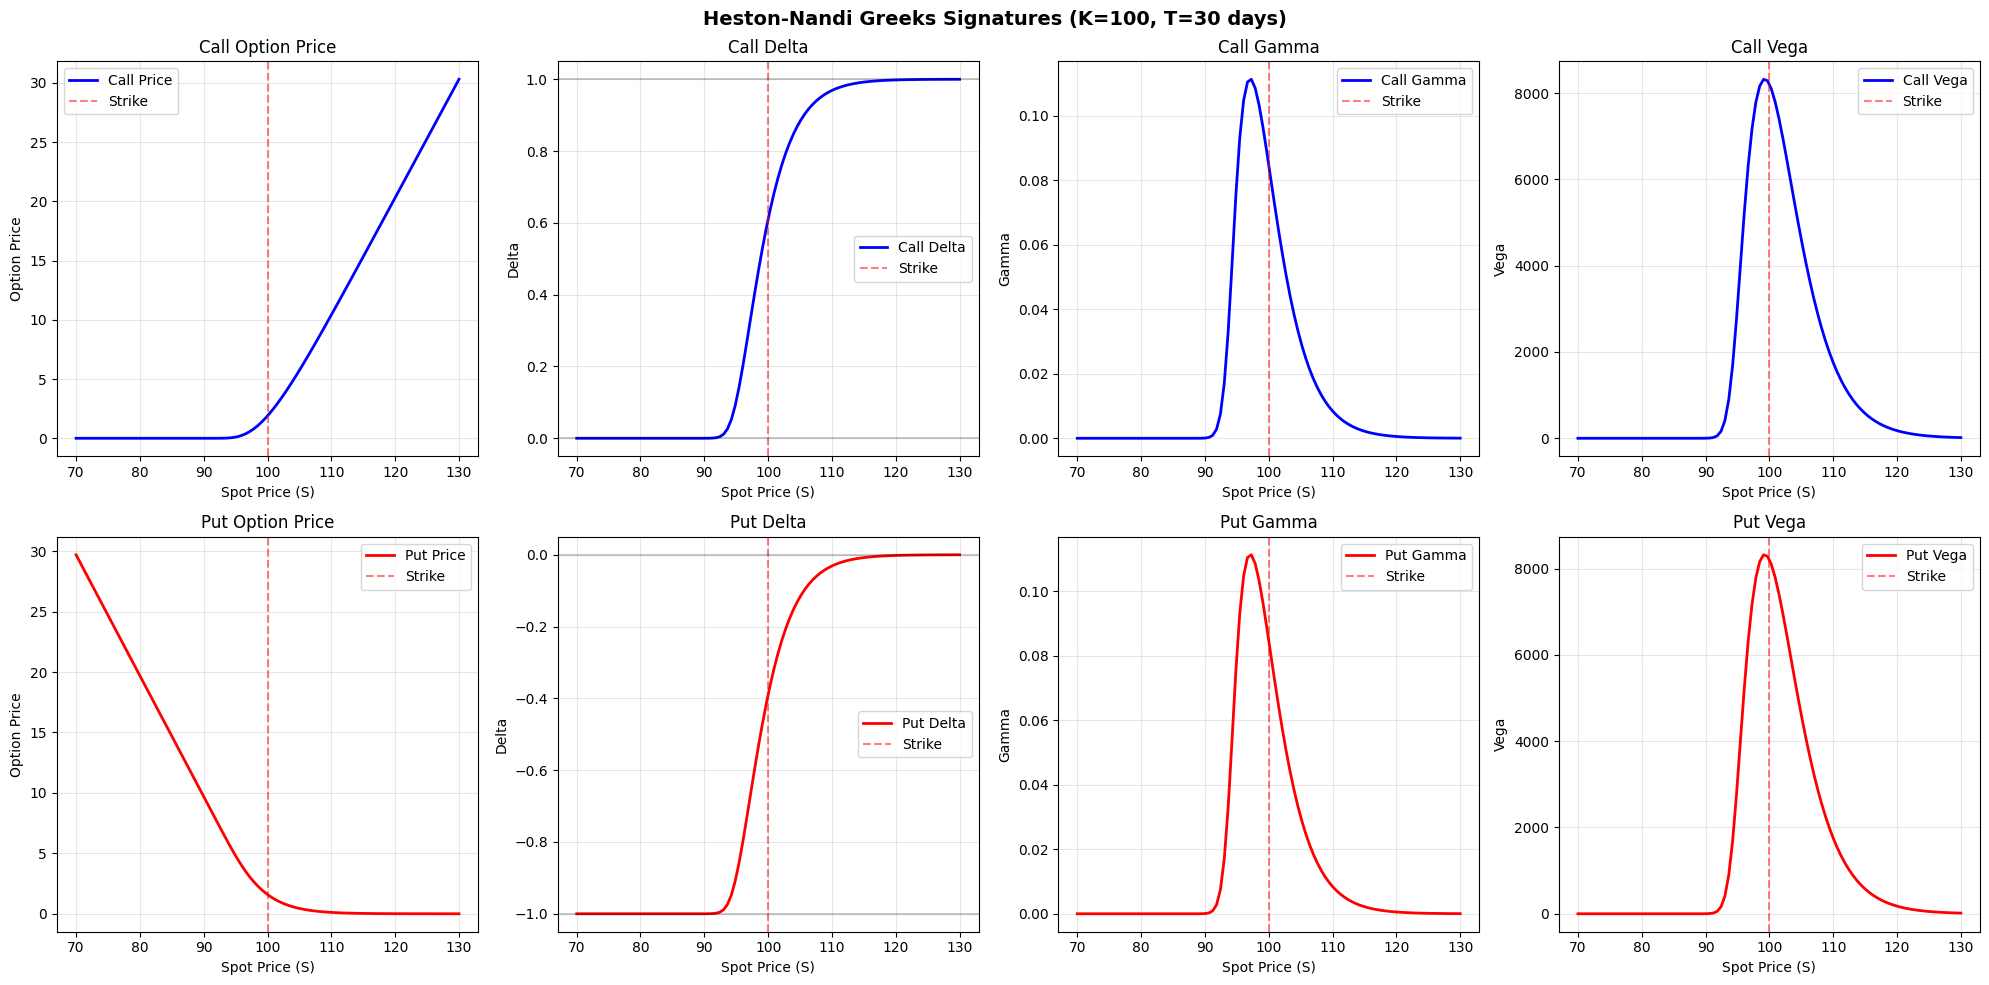

  Plot saved as 'heston_nandi_greeks_comparison.png'


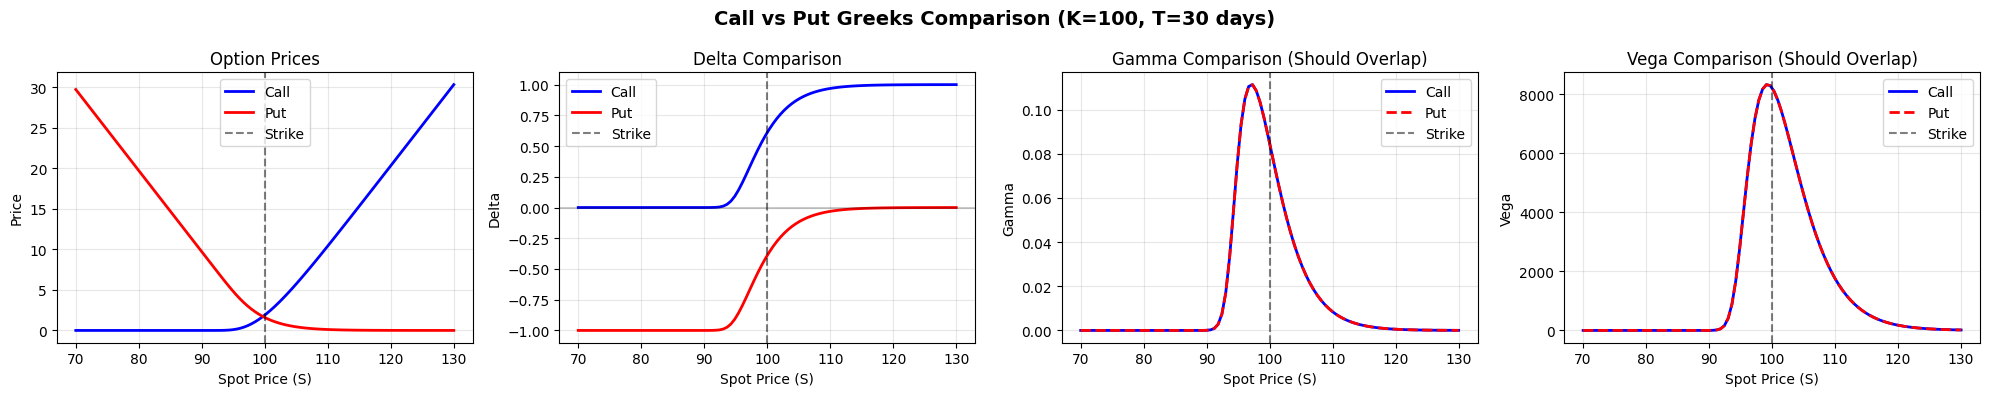

  Plot saved as 'heston_nandi_diagnostics.png'


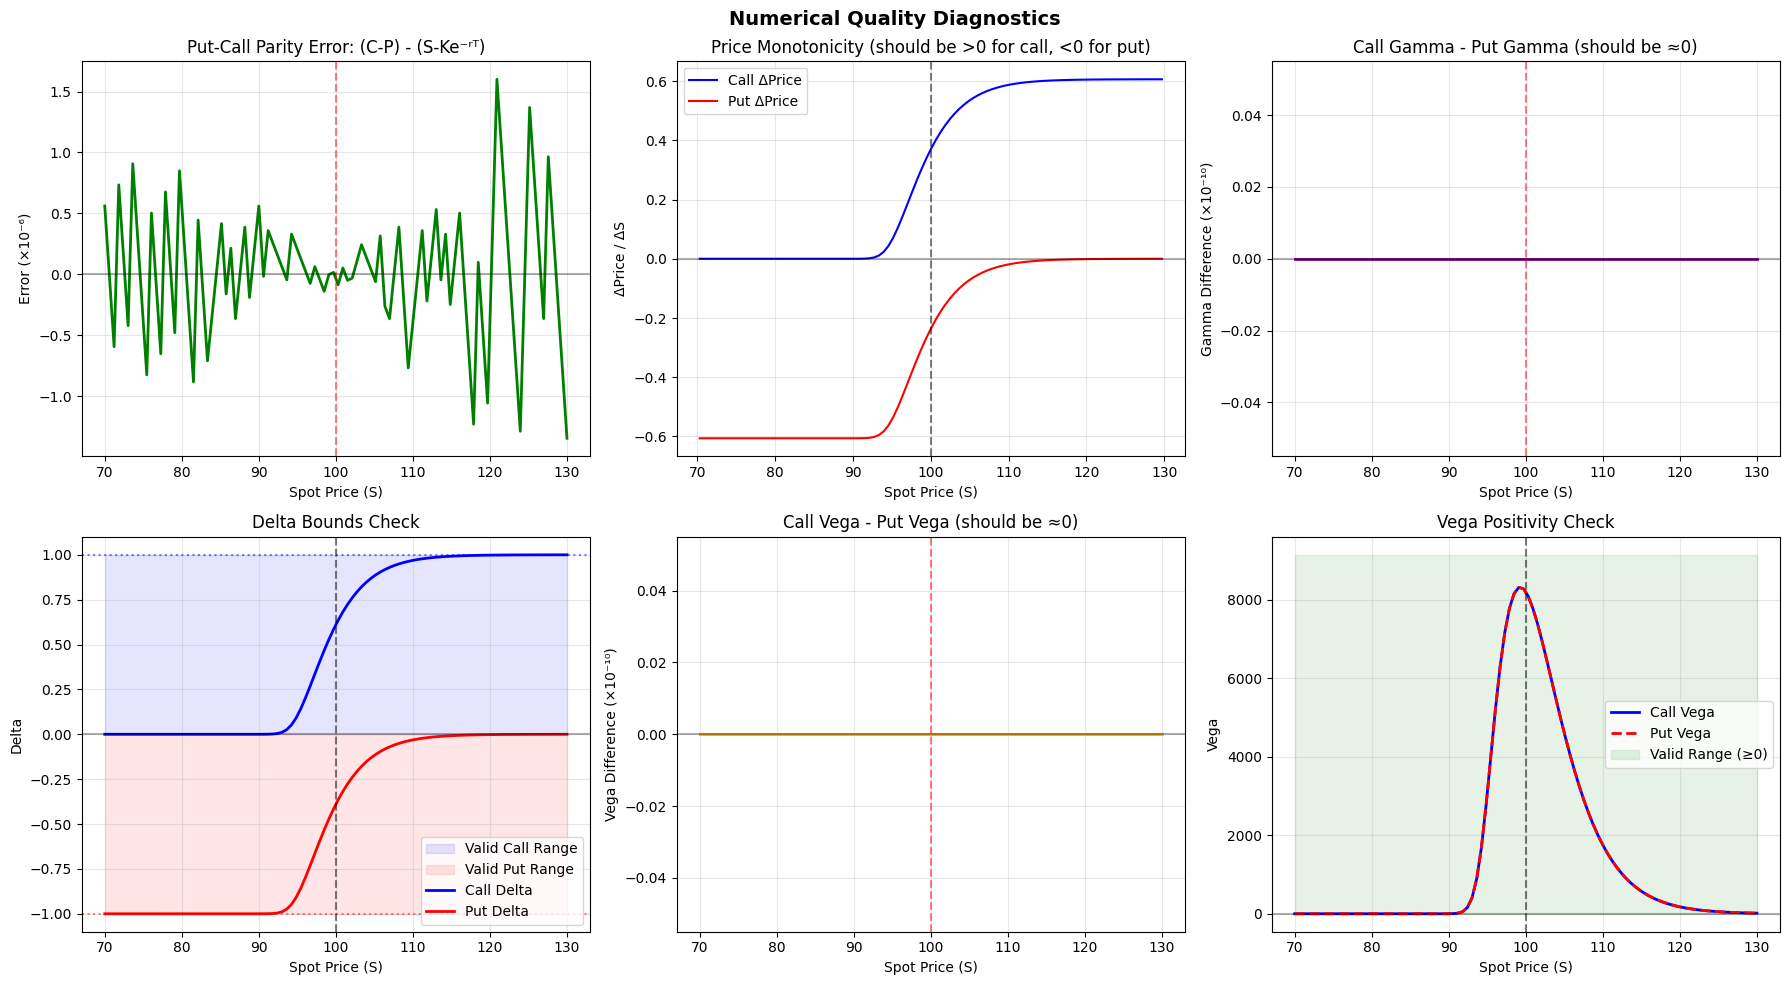


TEST COMPLETE


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_legendre as leggauss

# --------------------------------------------------------------------------
# Enhanced Test Script for Heston-Nandi Greeks with Visualization
# --------------------------------------------------------------------------

def test_heston_nandi_greeks():
    """
    Enhanced test script to compute and visualize Heston-Nandi option prices and Greeks.

    Required Data Types:
    --------------------
    Model Parameters (float):
        - omega: float, GARCH variance intercept (e.g., 1.5e-6)
        - alpha: float, ARCH coefficient (e.g., 1.5e-6)
        - beta: float, GARCH coefficient (e.g., 0.7)
        - gamma: float, risk premium parameter (e.g., 100.0)
        - lambda_: float, asymmetry parameter (e.g., -0.5)

    Market Parameters (float):
        - S: float or torch.Tensor, spot price(s)
        - K: float or torch.Tensor, strike price(s)
        - r_daily: float, daily risk-free rate (e.g., 0.0001 for 3.65% annual)
        - N: int, total number of days to expiration
        - step_idx: int, current time step (0 = today, N = expiration)

    Computation Parameters (int/float):
        - N_quad: int, number of quadrature points (default: 128)
        - u_max: float, upper integration limit (default: 100.0)
        - device: str, "cpu" or "cuda"

    Option Parameters (str):
        - option_type: str, "call" or "put"
    """

    # Model parameters (float)
    omega = 1.593749e-07
    alpha = 2.308475e-06
    beta = 0.689984
    gamma = 342.870019
    lambda_ = 0.420499


    # Market parameters
    r_daily = 0.0001  # Approximately 3.65% annual rate
    N = 30  # 30 days to expiration
    step_idx = 0  # Current time (today)

    # Strike price
    K = 100.0  # Strike price

    # Computation parameters
    N_quad = 2048  # int, number of quadrature points
    u_max = 1000.0  # float, integration upper limit
    device = "cpu"  # str, "cpu" or "cuda"

    print("=" * 70)
    print("HESTON-NANDI OPTION PRICING AND GREEKS")
    print("=" * 70)
    print("\nModel Parameters:")
    print(f"  omega:   {omega:.2e}")
    print(f"  alpha:   {alpha:.2e}")
    print(f"  beta:    {beta:.4f}")
    print(f"  gamma:   {gamma:.4f}")
    print(f"  lambda:  {lambda_:.4f}")

    print("\nMarket Parameters:")
    print(f"  Strike (K):        {K:.2f}")
    print(f"  Daily Rate:        {r_daily:.6f} ({r_daily * 365 * 100:.2f}% annual)")
    print(f"  Days to Expiry:    {N - step_idx}")

    print("\n" + "-" * 70)
    print("PRECOMPUTING CHARACTERISTIC FUNCTION COEFFICIENTS...")
    print("-" * 70)

    # Precompute coefficients
    precomputed = precompute_hn_coefficients(
        N=N,
        r_daily=r_daily,
        omega=omega,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        lambda_=lambda_,
        N_quad=N_quad,
        u_max=u_max,
        device=device
    )

    print(f"  Quadrature points: {N_quad}")
    print(f"  Integration limit: {u_max}")
    print(f"  Coefficient shape: {precomputed['coefficients'].shape}")
    print(f"  Device:            {device}")

    # Create spot price range for visualization
    # Range from 70% to 130% of strike
    S_min, S_max = 0.7 * K, 1.3 * K
    n_points = 100
    S_range = torch.linspace(S_min, S_max, n_points, dtype=torch.float64)
    K_tensor = torch.tensor([K], dtype=torch.float64)

    print("\n" + "-" * 70)
    print("COMPUTING GREEKS ACROSS SPOT PRICE RANGE...")
    print("-" * 70)
    print(f"  Spot range: [{S_min:.2f}, {S_max:.2f}]")
    print(f"  Grid points: {n_points}")

    # Compute Greeks for both call and put options
    results = {}

    for opt_type in ["call", "put"]:
        print(f"\n  Computing {opt_type.upper()} metrics...")

        prices = price_option_precomputed(
            S=S_range, K=K_tensor, step_idx=step_idx, r_daily=r_daily, N=N,
            option_type=opt_type, precomputed_data=precomputed
        )

        deltas = delta_precomputed_analytical(
            S=S_range, K=K_tensor, step_idx=step_idx, r_daily=r_daily, N=N,
            option_type=opt_type, precomputed_data=precomputed
        )

        gammas = gamma_precomputed_analytical(
            S=S_range, K=K_tensor, step_idx=step_idx, r_daily=r_daily, N=N,
            option_type=opt_type, precomputed_data=precomputed
        )

        vegas = vega_precomputed_analytical(
            S=S_range, K=K_tensor, step_idx=step_idx, r_daily=r_daily, N=N,
            option_type=opt_type, precomputed_data=precomputed,
            omega=omega, alpha=alpha, beta=beta, gamma=gamma, lambda_=lambda_
        )

        results[opt_type] = {
            'price': prices.numpy(),
            'delta': deltas.numpy(),
            'gamma': gammas.numpy(),
            'vega': vegas.numpy()
        }

    # Test single point computation
    print("\n" + "-" * 70)
    print("SINGLE POINT VERIFICATION (S=100, K=100)")
    print("-" * 70)

    S_test = 100.0
    for opt_type in ["call", "put"]:
        price = price_option_precomputed(
            S=S_test, K=K, step_idx=step_idx, r_daily=r_daily, N=N,
            option_type=opt_type, precomputed_data=precomputed
        )
        delta = delta_precomputed_analytical(
            S=S_test, K=K, step_idx=step_idx, r_daily=r_daily, N=N,
            option_type=opt_type, precomputed_data=precomputed
        )
        gamma_val = gamma_precomputed_analytical(
            S=S_test, K=K, step_idx=step_idx, r_daily=r_daily, N=N,
            option_type=opt_type, precomputed_data=precomputed
        )
        vega_val = vega_precomputed_analytical(
            S=S_test, K=K, step_idx=step_idx, r_daily=r_daily, N=N,
            option_type=opt_type, precomputed_data=precomputed,
            omega=omega, alpha=alpha, beta=beta, gamma=gamma, lambda_=lambda_
        )

        print(f"\n{opt_type.upper()}:")
        print(f"  Price: {price.item():.6f}")
        print(f"  Delta: {delta.item():.6f}")
        print(f"  Gamma: {gamma_val.item():.6f}")
        print(f"  Vega:  {vega_val.item():.6f}")

    # Verification tests
    print("\n" + "-" * 70)
    print("ROBUSTNESS CHECKS")
    print("-" * 70)

    # Check put-call parity: C - P = S - K*exp(-r*T)
    T = (N - step_idx) * r_daily
    S_pcp = S_range.numpy()
    theoretical_diff = S_pcp - K * np.exp(-T)
    actual_diff = results['call']['price'] - results['put']['price']
    pcp_error = np.abs(actual_diff - theoretical_diff)
    pcp_relative_error = pcp_error / np.maximum(np.abs(theoretical_diff), 1e-8)

    print(f"\n1. Put-Call Parity Check: C - P = S - K*exp(-r*T)")
    print(f"   Max absolute error: {np.max(pcp_error):.2e}")
    print(f"   Mean absolute error: {np.mean(pcp_error):.2e}")
    print(f"   Max relative error: {np.max(pcp_relative_error):.2e}")
    pcp_pass = np.max(pcp_error) < 1e-4
    print(f"   Status: {'✓ PASS' if pcp_pass else '✗ FAIL'}")
    if not pcp_pass:
        print(f"   Note: Error at S={S_pcp[np.argmax(pcp_error)]:.2f}, "
              f"expected {theoretical_diff[np.argmax(pcp_error)]:.6f}, "
              f"got {actual_diff[np.argmax(pcp_error)]:.6f}")

    # Check delta bounds: 0 <= call_delta <= 1, -1 <= put_delta <= 0
    call_delta_min = np.min(results['call']['delta'])
    call_delta_max = np.max(results['call']['delta'])
    put_delta_min = np.min(results['put']['delta'])
    put_delta_max = np.max(results['put']['delta'])

    call_delta_valid = (call_delta_min >= -0.02) and (call_delta_max <= 1.02)
    put_delta_valid = (put_delta_min >= -1.02) and (put_delta_max <= 0.02)

    print(f"\n2. Delta Bounds Check:")
    print(f"   Call delta range: [{call_delta_min:.4f}, {call_delta_max:.4f}]")
    print(f"   Expected: [0.0000, 1.0000] (±2% tolerance)")
    print(f"   Put delta range: [{put_delta_min:.4f}, {put_delta_max:.4f}]")
    print(f"   Expected: [-1.0000, 0.0000] (±2% tolerance)")
    delta_pass = call_delta_valid and put_delta_valid
    print(f"   Status: {'✓ PASS' if delta_pass else '✗ FAIL'}")

    # Check gamma positivity and equality
    call_gamma_min = np.min(results['call']['gamma'])
    gamma_tolerance = 1e-8
    gamma_positive = call_gamma_min >= -gamma_tolerance
    gamma_equal = np.allclose(results['call']['gamma'], results['put']['gamma'],
                              rtol=1e-6, atol=1e-9)

    print(f"\n3. Gamma Properties Check:")
    print(f"   Minimum gamma: {call_gamma_min:.2e}")
    print(f"   All gamma >= 0 (within {gamma_tolerance:.0e}): {gamma_positive}")
    print(f"   Call gamma ≈ Put gamma: {gamma_equal}")
    print(f"   Max |Call - Put| gamma: {np.max(np.abs(results['call']['gamma'] - results['put']['gamma'])):.2e}")
    gamma_pass = gamma_positive and gamma_equal
    print(f"   Status: {'✓ PASS' if gamma_pass else '✗ FAIL'}")

    # Check vega positivity and equality
    call_vega_min = np.min(results['call']['vega'])
    vega_tolerance = 1e-8
    vega_positive = call_vega_min >= -vega_tolerance
    vega_equal = np.allclose(results['call']['vega'], results['put']['vega'],
                             rtol=1e-6, atol=1e-9)

    print(f"\n4. Vega Properties Check:")
    print(f"   Minimum vega: {call_vega_min:.2e}")
    print(f"   All vega >= 0 (within {vega_tolerance:.0e}): {vega_positive}")
    print(f"   Call vega ≈ Put vega: {vega_equal}")
    print(f"   Max |Call - Put| vega: {np.max(np.abs(results['call']['vega'] - results['put']['vega'])):.2e}")
    vega_pass = vega_positive and vega_equal
    print(f"   Status: {'✓ PASS' if vega_pass else '✗ FAIL'}")

    # Check monotonicity
    call_price_diff = np.diff(results['call']['price'])
    put_price_diff = np.diff(results['put']['price'])

    call_violations = np.sum(call_price_diff < -1e-8)
    put_violations = np.sum(put_price_diff > 1e-8)

    call_price_monotone = call_violations == 0
    put_price_monotone = put_violations == 0

    print(f"\n5. Price Monotonicity Check:")
    print(f"   Call prices increasing with S: {call_price_monotone}")
    if not call_price_monotone:
        print(f"      {call_violations} violations (min diff: {np.min(call_price_diff):.2e})")
    print(f"   Put prices decreasing with S: {put_price_monotone}")
    if not put_price_monotone:
        print(f"      {put_violations} violations (max diff: {np.max(put_price_diff):.2e})")
    monotone_pass = call_price_monotone and put_price_monotone
    print(f"   Status: {'✓ PASS' if monotone_pass else '✗ FAIL'}")

    # Additional sanity checks
    print(f"\n6. Additional Sanity Checks:")

    # ATM gamma should be highest
    atm_idx = np.argmin(np.abs(S_pcp - K))
    gamma_peak_idx = np.argmax(results['call']['gamma'])
    gamma_peak_near_atm = np.abs(gamma_peak_idx - atm_idx) <= 3
    print(f"   Gamma peaks near ATM: {gamma_peak_near_atm}")
    print(f"      Peak at S={S_pcp[gamma_peak_idx]:.2f}, ATM at S={S_pcp[atm_idx]:.2f}")

    # ATM vega should be highest
    vega_peak_idx = np.argmax(results['call']['vega'])
    vega_peak_near_atm = np.abs(vega_peak_idx - atm_idx) <= 3
    print(f"   Vega peaks near ATM: {vega_peak_near_atm}")
    print(f"      Peak at S={S_pcp[vega_peak_idx]:.2f}, ATM at S={S_pcp[atm_idx]:.2f}")

    # Delta should be ~0.5 at ATM for calls
    atm_delta = results['call']['delta'][atm_idx]
    delta_atm_reasonable = 0.35 <= atm_delta <= 0.65
    print(f"   ATM call delta ≈ 0.5: {delta_atm_reasonable}")
    print(f"      ATM delta = {atm_delta:.4f}")

    # Deep ITM call should have delta near 1
    itm_idx = np.argmin(np.abs(S_pcp - 1.2*K))
    itm_delta = results['call']['delta'][itm_idx]
    delta_itm_high = itm_delta >= 0.85
    print(f"   Deep ITM call delta ≈ 1: {delta_itm_high}")
    print(f"      Delta at S={S_pcp[itm_idx]:.2f} is {itm_delta:.4f}")

    sanity_pass = gamma_peak_near_atm and vega_peak_near_atm and delta_atm_reasonable and delta_itm_high
    print(f"   Status: {'✓ PASS' if sanity_pass else '✗ FAIL'}")

    # Overall summary
    all_pass = pcp_pass and delta_pass and gamma_pass and vega_pass and monotone_pass and sanity_pass
    print(f"\n{'='*70}")
    print(f"OVERALL ROBUSTNESS: {'✓ ALL CHECKS PASSED' if all_pass else '⚠ SOME CHECKS FAILED'}")
    print(f"{'='*70}")

    # Plotting
    print("\n" + "-" * 70)
    print("GENERATING VISUALIZATION...")
    print("-" * 70)

    S_plot = S_range.numpy()

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'Heston-Nandi Greeks Signatures (K={K:.0f}, T={N-step_idx} days)',
                 fontsize=14, fontweight='bold')

    # Call Option Plots
    axes[0, 0].plot(S_plot, results['call']['price'], 'b-', linewidth=2, label='Call Price')
    axes[0, 0].axvline(K, color='r', linestyle='--', alpha=0.5, label='Strike')
    axes[0, 0].set_xlabel('Spot Price (S)')
    axes[0, 0].set_ylabel('Option Price')
    axes[0, 0].set_title('Call Option Price')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()

    axes[0, 1].plot(S_plot, results['call']['delta'], 'b-', linewidth=2, label='Call Delta')
    axes[0, 1].axvline(K, color='r', linestyle='--', alpha=0.5, label='Strike')
    axes[0, 1].axhline(0, color='k', linestyle='-', alpha=0.2)
    axes[0, 1].axhline(1, color='k', linestyle='-', alpha=0.2)
    axes[0, 1].set_xlabel('Spot Price (S)')
    axes[0, 1].set_ylabel('Delta')
    axes[0, 1].set_title('Call Delta')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()

    axes[0, 2].plot(S_plot, results['call']['gamma'], 'b-', linewidth=2, label='Call Gamma')
    axes[0, 2].axvline(K, color='r', linestyle='--', alpha=0.5, label='Strike')
    axes[0, 2].set_xlabel('Spot Price (S)')
    axes[0, 2].set_ylabel('Gamma')
    axes[0, 2].set_title('Call Gamma')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].legend()

    axes[0, 3].plot(S_plot, results['call']['vega'], 'b-', linewidth=2, label='Call Vega')
    axes[0, 3].axvline(K, color='r', linestyle='--', alpha=0.5, label='Strike')
    axes[0, 3].set_xlabel('Spot Price (S)')
    axes[0, 3].set_ylabel('Vega')
    axes[0, 3].set_title('Call Vega')
    axes[0, 3].grid(True, alpha=0.3)
    axes[0, 3].legend()

    # Put Option Plots
    axes[1, 0].plot(S_plot, results['put']['price'], 'r-', linewidth=2, label='Put Price')
    axes[1, 0].axvline(K, color='r', linestyle='--', alpha=0.5, label='Strike')
    axes[1, 0].set_xlabel('Spot Price (S)')
    axes[1, 0].set_ylabel('Option Price')
    axes[1, 0].set_title('Put Option Price')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()

    axes[1, 1].plot(S_plot, results['put']['delta'], 'r-', linewidth=2, label='Put Delta')
    axes[1, 1].axvline(K, color='r', linestyle='--', alpha=0.5, label='Strike')
    axes[1, 1].axhline(0, color='k', linestyle='-', alpha=0.2)
    axes[1, 1].axhline(-1, color='k', linestyle='-', alpha=0.2)
    axes[1, 1].set_xlabel('Spot Price (S)')
    axes[1, 1].set_ylabel('Delta')
    axes[1, 1].set_title('Put Delta')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()

    axes[1, 2].plot(S_plot, results['put']['gamma'], 'r-', linewidth=2, label='Put Gamma')
    axes[1, 2].axvline(K, color='r', linestyle='--', alpha=0.5, label='Strike')
    axes[1, 2].set_xlabel('Spot Price (S)')
    axes[1, 2].set_ylabel('Gamma')
    axes[1, 2].set_title('Put Gamma')
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].legend()

    axes[1, 3].plot(S_plot, results['put']['vega'], 'r-', linewidth=2, label='Put Vega')
    axes[1, 3].axvline(K, color='r', linestyle='--', alpha=0.5, label='Strike')
    axes[1, 3].set_xlabel('Spot Price (S)')
    axes[1, 3].set_ylabel('Vega')
    axes[1, 3].set_title('Put Vega')
    axes[1, 3].grid(True, alpha=0.3)
    axes[1, 3].legend()

    plt.tight_layout()
    plt.savefig('heston_nandi_greeks_signature.png', dpi=300, bbox_inches='tight')
    print("  Plot saved as 'heston_nandi_greeks_signature.png'")
    plt.show()

    # Additional comparison plot
    fig2, axes2 = plt.subplots(1, 4, figsize=(20, 4))
    fig2.suptitle(f'Call vs Put Greeks Comparison (K={K:.0f}, T={N-step_idx} days)',
                  fontsize=14, fontweight='bold')

    axes2[0].plot(S_plot, results['call']['price'], 'b-', linewidth=2, label='Call')
    axes2[0].plot(S_plot, results['put']['price'], 'r-', linewidth=2, label='Put')
    axes2[0].axvline(K, color='k', linestyle='--', alpha=0.5, label='Strike')
    axes2[0].set_xlabel('Spot Price (S)')
    axes2[0].set_ylabel('Price')
    axes2[0].set_title('Option Prices')
    axes2[0].grid(True, alpha=0.3)
    axes2[0].legend()

    axes2[1].plot(S_plot, results['call']['delta'], 'b-', linewidth=2, label='Call')
    axes2[1].plot(S_plot, results['put']['delta'], 'r-', linewidth=2, label='Put')
    axes2[1].axvline(K, color='k', linestyle='--', alpha=0.5, label='Strike')
    axes2[1].axhline(0, color='k', linestyle='-', alpha=0.2)
    axes2[1].set_xlabel('Spot Price (S)')
    axes2[1].set_ylabel('Delta')
    axes2[1].set_title('Delta Comparison')
    axes2[1].grid(True, alpha=0.3)
    axes2[1].legend()

    axes2[2].plot(S_plot, results['call']['gamma'], 'b-', linewidth=2, label='Call')
    axes2[2].plot(S_plot, results['put']['gamma'], 'r--', linewidth=2, label='Put')
    axes2[2].axvline(K, color='k', linestyle='--', alpha=0.5, label='Strike')
    axes2[2].set_xlabel('Spot Price (S)')
    axes2[2].set_ylabel('Gamma')
    axes2[2].set_title('Gamma Comparison (Should Overlap)')
    axes2[2].grid(True, alpha=0.3)
    axes2[2].legend()

    axes2[3].plot(S_plot, results['call']['vega'], 'b-', linewidth=2, label='Call')
    axes2[3].plot(S_plot, results['put']['vega'], 'r--', linewidth=2, label='Put')
    axes2[3].axvline(K, color='k', linestyle='--', alpha=0.5, label='Strike')
    axes2[3].set_xlabel('Spot Price (S)')
    axes2[3].set_ylabel('Vega')
    axes2[3].set_title('Vega Comparison (Should Overlap)')
    axes2[3].grid(True, alpha=0.3)
    axes2[3].legend()

    plt.tight_layout()
    plt.savefig('heston_nandi_greeks_comparison.png', dpi=300, bbox_inches='tight')
    print("  Plot saved as 'heston_nandi_greeks_comparison.png'")
    plt.show()

    # Diagnostic plots for numerical quality
    fig3, axes3 = plt.subplots(2, 3, figsize=(18, 10))
    fig3.suptitle(f'Numerical Quality Diagnostics', fontsize=14, fontweight='bold')

    # Put-call parity error
    T = (N - step_idx) * r_daily
    theoretical_diff = S_plot - K * np.exp(-T)
    actual_diff = results['call']['price'] - results['put']['price']
    pcp_error = actual_diff - theoretical_diff

    axes3[0, 0].plot(S_plot, pcp_error * 1e6, 'g-', linewidth=2)
    axes3[0, 0].axvline(K, color='r', linestyle='--', alpha=0.5)
    axes3[0, 0].axhline(0, color='k', linestyle='-', alpha=0.3)
    axes3[0, 0].set_xlabel('Spot Price (S)')
    axes3[0, 0].set_ylabel('Error (×10⁻⁶)')
    axes3[0, 0].set_title('Put-Call Parity Error: (C-P) - (S-Ke⁻ʳᵀ)')
    axes3[0, 0].grid(True, alpha=0.3)

    # Price differences (monotonicity check)
    call_diffs = np.diff(results['call']['price'])
    put_diffs = np.diff(results['put']['price'])
    S_diff = S_plot[:-1] + np.diff(S_plot)/2

    axes3[0, 1].plot(S_diff, call_diffs, 'b-', linewidth=1.5, label='Call ΔPrice')
    axes3[0, 1].plot(S_diff, put_diffs, 'r-', linewidth=1.5, label='Put ΔPrice')
    axes3[0, 1].axvline(K, color='k', linestyle='--', alpha=0.5)
    axes3[0, 1].axhline(0, color='k', linestyle='-', alpha=0.3)
    axes3[0, 1].set_xlabel('Spot Price (S)')
    axes3[0, 1].set_ylabel('ΔPrice / ΔS')
    axes3[0, 1].set_title('Price Monotonicity (should be >0 for call, <0 for put)')
    axes3[0, 1].grid(True, alpha=0.3)
    axes3[0, 1].legend()

    # Gamma difference between call and put
    gamma_diff = results['call']['gamma'] - results['put']['gamma']
    axes3[0, 2].plot(S_plot, gamma_diff * 1e10, 'purple', linewidth=2)
    axes3[0, 2].axvline(K, color='r', linestyle='--', alpha=0.5)
    axes3[0, 2].axhline(0, color='k', linestyle='-', alpha=0.3)
    axes3[0, 2].set_xlabel('Spot Price (S)')
    axes3[0, 2].set_ylabel('Gamma Difference (×10⁻¹⁰)')
    axes3[0, 2].set_title('Call Gamma - Put Gamma (should be ≈0)')
    axes3[0, 2].grid(True, alpha=0.3)

    # Delta bounds visualization
    axes3[1, 0].fill_between([S_plot[0], S_plot[-1]], [0, 0], [1, 1],
                             color='blue', alpha=0.1, label='Valid Call Range')
    axes3[1, 0].fill_between([S_plot[0], S_plot[-1]], [-1, -1], [0, 0],
                             color='red', alpha=0.1, label='Valid Put Range')
    axes3[1, 0].plot(S_plot, results['call']['delta'], 'b-', linewidth=2, label='Call Delta')
    axes3[1, 0].plot(S_plot, results['put']['delta'], 'r-', linewidth=2, label='Put Delta')
    axes3[1, 0].axvline(K, color='k', linestyle='--', alpha=0.5)
    axes3[1, 0].axhline(0, color='k', linestyle='-', alpha=0.3)
    axes3[1, 0].axhline(1, color='blue', linestyle=':', alpha=0.5)
    axes3[1, 0].axhline(-1, color='red', linestyle=':', alpha=0.5)
    axes3[1, 0].set_xlabel('Spot Price (S)')
    axes3[1, 0].set_ylabel('Delta')
    axes3[1, 0].set_title('Delta Bounds Check')
    axes3[1, 0].set_ylim([-1.1, 1.1])
    axes3[1, 0].grid(True, alpha=0.3)
    axes3[1, 0].legend(loc='best')

    # Vega difference between call and put
    vega_diff = results['call']['vega'] - results['put']['vega']
    axes3[1, 1].plot(S_plot, vega_diff * 1e10, 'orange', linewidth=2)
    axes3[1, 1].axvline(K, color='r', linestyle='--', alpha=0.5)
    axes3[1, 1].axhline(0, color='k', linestyle='-', alpha=0.3)
    axes3[1, 1].set_xlabel('Spot Price (S)')
    axes3[1, 1].set_ylabel('Vega Difference (×10⁻¹⁰)')
    axes3[1, 1].set_title('Call Vega - Put Vega (should be ≈0)')
    axes3[1, 1].grid(True, alpha=0.3)

    # Vega positivity check
    axes3[1, 2].plot(S_plot, results['call']['vega'], 'b-', linewidth=2, label='Call Vega')
    axes3[1, 2].plot(S_plot, results['put']['vega'], 'r--', linewidth=2, label='Put Vega')
    axes3[1, 2].axvline(K, color='k', linestyle='--', alpha=0.5)
    axes3[1, 2].axhline(0, color='k', linestyle='-', alpha=0.3)
    axes3[1, 2].fill_between([S_plot[0], S_plot[-1]], [0, 0],
                             [np.max(results['call']['vega'])*1.1, np.max(results['call']['vega'])*1.1],
                             color='green', alpha=0.1, label='Valid Range (≥0)')
    axes3[1, 2].set_xlabel('Spot Price (S)')
    axes3[1, 2].set_ylabel('Vega')
    axes3[1, 2].set_title('Vega Positivity Check')
    axes3[1, 2].grid(True, alpha=0.3)
    axes3[1, 2].legend(loc='best')

    plt.tight_layout()
    plt.savefig('heston_nandi_diagnostics.png', dpi=300, bbox_inches='tight')
    print("  Plot saved as 'heston_nandi_diagnostics.png'")
    plt.show()

    print("\n" + "=" * 70)
    print("TEST COMPLETE")
    print("=" * 70)

    return results, S_plot


if __name__ == "__main__":
    results, spot_prices = test_heston_nandi_greeks()

#RL Hedging Environment
###The following code consists of a class that utilizes an LSTM feed forward layer with hidden states that is able to adaptively output the respective delta, gamma, and vega arrays (if applicable) for the n hedging instruments available for usage.
###The hedging framework uses the GARCH(1, 1) Sim with previously calibrated parameters.
###The hedging problem is defined as a portfolio optimization problem of choosing n linearly independent hedging instruments to hedge n greek risks. For now, the code supports 3 hedge instruments: a stock (and a risk free bond), and two options with varying strikes, maturities, and types.


episode: 1


b: tensor([6.9603e-01, 2.5672e-02, 9.5300e+02])
first path: tensor([[-6.2050e-01,  7.0312e-01,  1.0330e+00],
        [-7.6092e-01,  9.2613e-01,  9.3115e-01],
        [-6.9695e-01,  8.2292e-01,  9.7975e-01],
        [-6.9574e-01,  8.1935e-01,  9.8302e-01],
        [-7.4678e-01,  8.9881e-01,  9.4831e-01],
        [-8.6133e-01,  1.0766e+00,  8.7163e-01],
        [-8.3623e-01,  1.0358e+00,  8.9087e-01],
        [-8.0379e-01,  9.8347e-01,  9.1546e-01],
        [-8.0673e-01,  9.8636e-01,  9.1587e-01],
        [-8.6293e-01,  1.0722e+00,  8.8018e-01],
        [-9.6204e-01,  1.2228e+00,  8.1836e-01],
        [-1.0014e+00,  1.2810e+00,  7.9625e-01],
        [-1.0299e+00,  1.3223e+00,  7.8123e-01],
        [-9.5918e-01,  1.2131e+00,  8.2751e-01],
        [-9.5057e-01,  1.1982e+00,  8.3544e-01],
        [-9.3341e-01,  1.1701e+00,  8.4891e-01],
        [-9.0993e-01,  1.1323e+00,  8.6662e-01],
        [-9.6142e-01,  1.2093e+00,  8.3610e-01],
        [-9.7783e-01,  1.2325e+00,  8.2829e-01],
        [

b: tensor([6.9603e-01, 2.5672e-02, 9.5300e+02])
first path: tensor([[-6.2050e-01,  7.0312e-01,  1.0330e+00],
        [-5.1381e-01,  5.2668e-01,  1.1214e+00],
        [-5.2007e-01,  5.3549e-01,  1.1186e+00],
        [-6.4142e-01,  7.3214e-01,  1.0239e+00],
        [-7.1362e-01,  8.4620e-01,  9.7227e-01],
        [-6.7121e-01,  7.7679e-01,  1.0061e+00],
        [-6.1904e-01,  6.9108e-01,  1.0484e+00],
        [-5.8843e-01,  6.3973e-01,  1.0749e+00],
        [-6.0168e-01,  6.5963e-01,  1.0669e+00],
        [-6.5850e-01,  7.4972e-01,  1.0255e+00],
        [-7.2561e-01,  8.5512e-01,  9.7818e-01],
        [-5.6619e-01,  5.9687e-01,  1.1026e+00],
        [-4.6439e-01,  4.2723e-01,  1.1901e+00],
        [-3.7552e-01,  2.7601e-01,  1.2722e+00],
        [-2.7060e-01,  9.3842e-02,  1.3761e+00],
        [-1.3769e-01, -1.4371e-01,  1.5211e+00],
        [-1.1544e-01, -1.8537e-01,  1.5490e+00],
        [-2.5519e-01,  6.2709e-02,  1.3988e+00],
        [-3.0676e-01,  1.5077e-01,  1.3497e+00],
        [

KeyboardInterrupt: 

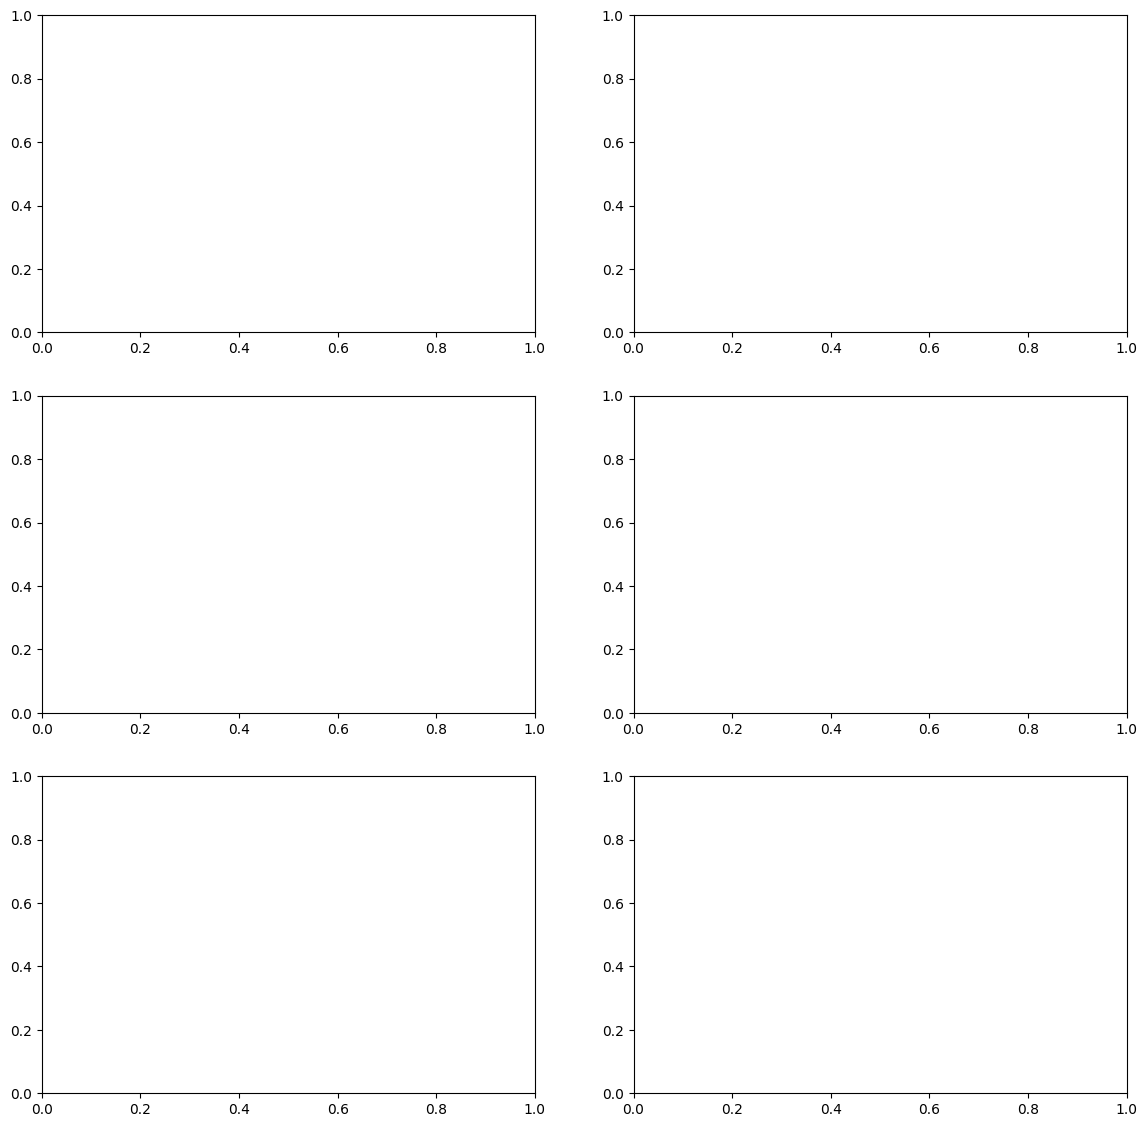

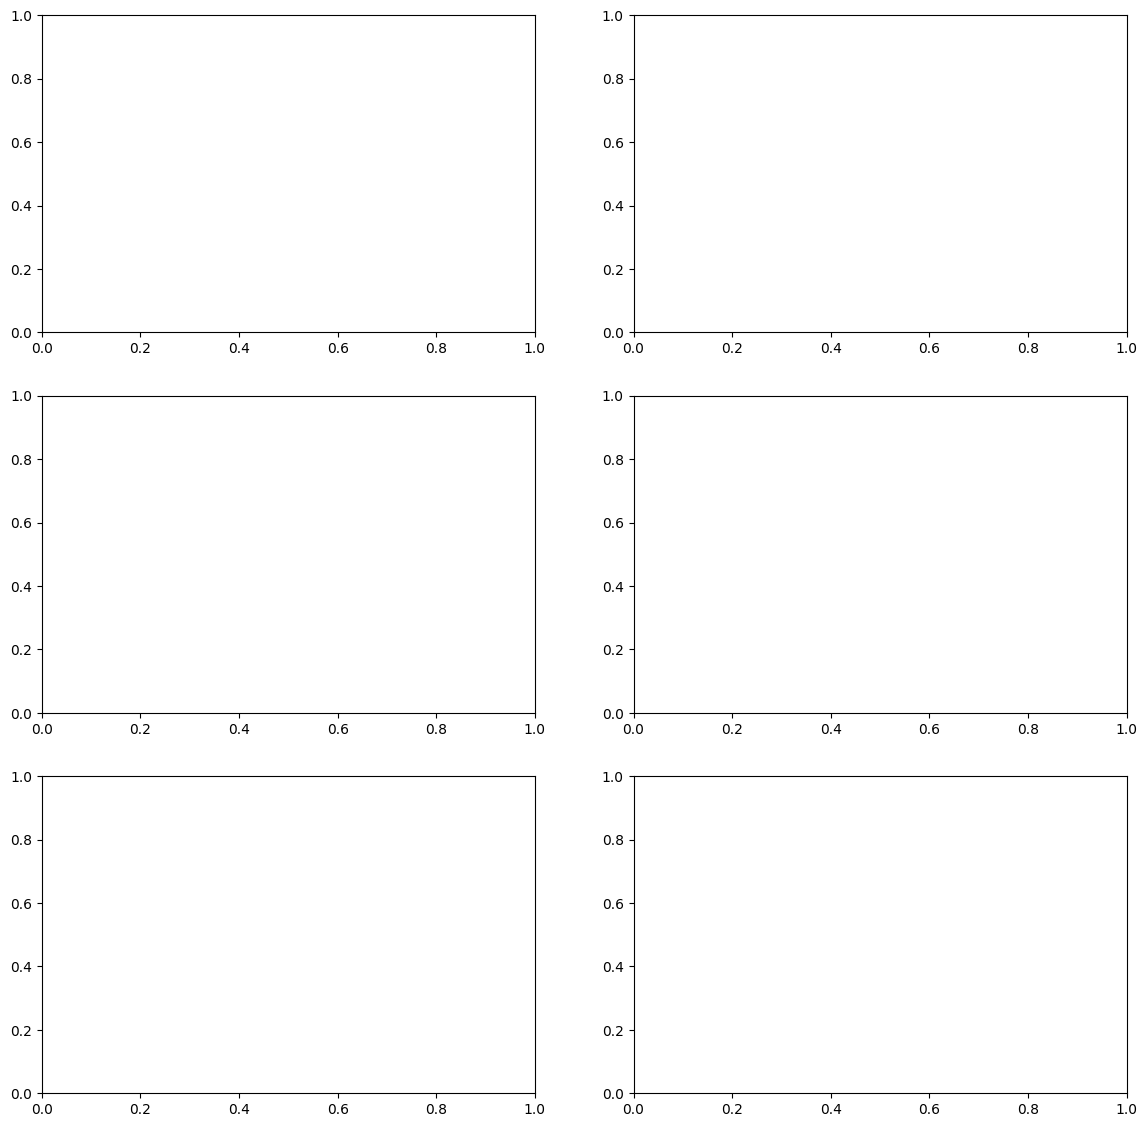

In [ ]:
class PolicyNetGARCH(nn.Module):
    def __init__(self, obs_dim=5, hidden_size=128, n_hedging_instruments=2):
        super().__init__()

        self.n_hedging_instruments = n_hedging_instruments

        # LSTM to process the observation sequence
        self.lstm = nn.LSTM(obs_dim, hidden_size, num_layers=2, batch_first=True)

        # Shared fully connected layer
        self.fc1 = nn.Linear(hidden_size, hidden_size)

        # Create output heads dynamically for each instrument
        self.instrument_heads = nn.ModuleList([
            nn.Linear(hidden_size, 1) for _ in range(n_hedging_instruments)
        ])

        self.hidden_size = hidden_size

        # Initialize weights
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, obs_sequence):
        # LSTM processing
        lstm_out, _ = self.lstm(obs_sequence)
        x = F.relu(self.fc1(lstm_out))

        # Get positions for all instruments
        outputs = []
        for i, head in enumerate(self.instrument_heads):
            output = head(x).squeeze(-1)
            outputs.append(output)

        return outputs  # List of length n_hedging_instruments


# --------------------------------------------------------------------------
# Hedging Environment (Batched Trajectory Simulation)
# --------------------------------------------------------------------------
class HedgingEnvGARCH:
    def __init__(self, sim, garch_params=None, precomputed_data_1yr=None,
                 precomputed_data_1_5yr=None, precomputed_data_2yr=None,
                 n_hedging_instruments=2, dt_min=1e-10, device="cpu",
                 instrument_strikes=None, instrument_types=None):
        self.sim = sim
        self.M = sim.M
        self.N = sim.N
        self.dt_min = dt_min
        self.device = torch.device(device)

        self.garch_params = garch_params or {
            "omega": 1.593749e-07,
            "alpha": 2.308475e-06,
            "beta": 0.689984,
            "gamma": 342.870019,
            "lambda": 0.420499,
            "sigma0": sim.sigma,
        }

        self.n_hedging_instruments = n_hedging_instruments
        self.precomputed_data_1yr = precomputed_data_1yr
        self.precomputed_data_1_5yr = precomputed_data_1_5yr
        self.precomputed_data_2yr = precomputed_data_2yr

        # Define instrument maturities based on n_hedging_instruments
        if n_hedging_instruments == 1:
            self.instrument_maturities = [252]  # Stock only
            self.instrument_strikes = [None]
        elif n_hedging_instruments == 2:
            self.instrument_maturities = [252, 504]  # Stock + 2yr
            if instrument_strikes is None:
                self.instrument_strikes = [None, self.sim.K]  # Default ATM
            else:
                self.instrument_strikes = [None, instrument_strikes[0]]
        elif n_hedging_instruments == 3:
            self.instrument_maturities = [252, 378, 504]  # Stock + 1.5yr + 2yr
            if instrument_strikes is None:
                self.instrument_strikes = [None, self.sim.K, self.sim.K]  # Default ATM
            else:
                self.instrument_strikes = [None, instrument_strikes[0], instrument_strikes[1]]
        else:
            raise ValueError(f"n_hedging_instruments must be 1, 2, or 3, got {n_hedging_instruments}")

        # Define instrument types (call/put) based on n_hedging_instruments
        if instrument_types is None:
            # Default: all hedging instruments are same type as the option we're hedging
            self.instrument_types = [None] + [self.sim.option_type] * (n_hedging_instruments - 1)
        else:
            # Validate input
            if len(instrument_types) != n_hedging_instruments - 1:
                raise ValueError(f"instrument_types must have length {n_hedging_instruments - 1}, got {len(instrument_types)}")
            self.instrument_types = [None] + instrument_types  # None for stock, then user-specified types

        self.omega = float(self.garch_params["omega"])
        self.alpha = float(self.garch_params["alpha"])
        self.beta = float(self.garch_params["beta"])
        self.gamma = float(self.garch_params["gamma"])
        self.lambda_ = float(self.garch_params["lambda"])

        self.S0 = self.sim.S0
        self.K = self.sim.K
        self.T = self.sim.T
        self.r = self.sim.r / 252.0
        self.option_type = self.sim.option_type
        self.side = self.sim.side
        self.contract_size = self.sim.contract_size
        self.TCP = getattr(self.sim, "TCP", 0.0)

        self.sigma0 = float(self.garch_params["sigma0"])
        self.sigma_t = torch.full((self.M,), self.sigma0, dtype=torch.float32, device=self.device)
        self.h_t = (self.sigma_t ** 2 / 252)

    def reset(self):
        self.Z = torch.randn((self.M, self.N), dtype=torch.float32, device=self.device)
        sigma0_annual = float(self.garch_params["sigma0"])
        self.sigma_t = torch.full((self.M,), sigma0_annual, dtype=torch.float32, device=self.device)
        self.h_t = (self.sigma_t ** 2 / 252)

    def compute_all_paths_hn_delta(self, S_trajectory):
        """Compute Heston-Nandi delta for ALL paths."""
        M, N_plus_1 = S_trajectory.shape
        HN_delta_trajectory = torch.zeros((M, N_plus_1), dtype=torch.float32, device=self.device)

        for t in range(N_plus_1):
            S_t = S_trajectory[:, t]
            D_t = delta_precomputed_analytical(
                S=S_t, K=self.K, step_idx=t, r_daily=self.r, N=self.N,
                option_type=self.option_type, precomputed_data=self.precomputed_data_1yr
            )
            HN_delta_trajectory[:, t] = D_t

        return HN_delta_trajectory

    def compute_all_paths_hn_gamma(self, S_trajectory):
        """Compute Heston-Nandi gamma for ALL paths."""
        M, N_plus_1 = S_trajectory.shape
        HN_gamma_trajectory = torch.zeros((M, N_plus_1), dtype=torch.float32, device=self.device)

        for t in range(N_plus_1):
            S_t = S_trajectory[:, t]
            G_t = gamma_precomputed_analytical(
                S=S_t, K=self.K, step_idx=t, r_daily=self.r, N=self.N,
                option_type=self.option_type, precomputed_data=self.precomputed_data_1yr
            )
            HN_gamma_trajectory[:, t] = G_t

        return HN_gamma_trajectory

    def compute_all_paths_hn_vega(self, S_trajectory):
        """Compute Heston-Nandi vega for ALL paths."""
        M, N_plus_1 = S_trajectory.shape
        HN_vega_trajectory = torch.zeros((M, N_plus_1), dtype=torch.float32, device=self.device)

        for t in range(N_plus_1):
            S_t = S_trajectory[:, t]
            V_t = vega_precomputed_analytical(
                S=S_t, K=self.K, step_idx=t, r_daily=self.r, N=self.N, omega=self.omega,
                alpha=self.alpha, beta=self.beta, gamma=self.gamma, lambda_=self.lambda_, sigma0=self.sigma0,
                option_type=self.option_type, precomputed_data=self.precomputed_data_1yr
            )
            HN_vega_trajectory[:, t] = V_t

        return HN_vega_trajectory

    def compute_hn_option_positions(self, S_trajectory, portfolio_greeks):
        """
        Compute optimal hedge positions using linear algebra for n Greeks with n instruments.

        Solves the system:
            A @ x = b
        where A[i,j] = greek_i of instrument_j

        Args:
            S_trajectory: [M, N+1] stock prices
            portfolio_greeks: dict with keys like 'delta', 'gamma', 'vega' containing [M, N+1] tensors

        Returns:
            positions: [M, N+1, n_instruments] positions for each instrument
        """
        M, N_plus_1 = S_trajectory.shape
        n = self.n_hedging_instruments
        epsilon = 1e-10

        # Define which greeks to hedge based on n
        if n == 1:
            greek_names = ['delta']
        elif n == 2:
            greek_names = ['delta', 'gamma']
        elif n == 3:
            greek_names = ['delta', 'gamma', 'vega']

        # Compute greeks for all hedging instruments
        instrument_greeks = []

        for j, maturity_days in enumerate(self.instrument_maturities):
            if maturity_days == 252:  # Stock
                greeks = {
                    'delta': torch.ones((M, N_plus_1), device=self.device),
                    'gamma': torch.zeros((M, N_plus_1), device=self.device),
                    'vega': torch.zeros((M, N_plus_1), device=self.device),
                }
            else:  # Options
                if maturity_days == 378:
                    precomputed = self.precomputed_data_1_5yr
                elif maturity_days == 504:
                    precomputed = self.precomputed_data_2yr
                else:
                    raise ValueError(f"No precomputed data for maturity {maturity_days}")

                # GET THE OPTION TYPE FOR THIS INSTRUMENT
                inst_option_type = self.instrument_types[j]

                delta_inst = torch.zeros((M, N_plus_1), device=self.device)
                gamma_inst = torch.zeros((M, N_plus_1), device=self.device)
                vega_inst = torch.zeros((M, N_plus_1), device=self.device)

                for t in range(N_plus_1):
                    S_t = S_trajectory[:, t]

                    delta_inst[:, t] = delta_precomputed_analytical(
                        S=S_t, K=self.instrument_strikes[j], step_idx=t, r_daily=self.r, N=maturity_days,
                        option_type=inst_option_type,  # USE INSTRUMENT TYPE
                        precomputed_data=precomputed
                    )

                    gamma_inst[:, t] = gamma_precomputed_analytical(
                        S=S_t, K=self.instrument_strikes[j], step_idx=t, r_daily=self.r, N=maturity_days,
                        option_type=inst_option_type,  # USE INSTRUMENT TYPE
                        precomputed_data=precomputed
                    )

                    if n >= 3:
                        vega_inst[:, t] = vega_precomputed_analytical(
                            S=S_t, K=self.instrument_strikes[j], step_idx=t, r_daily=self.r, N=maturity_days, omega=self.omega,
                            alpha=self.alpha, beta=self.beta, gamma=self.gamma, lambda_=self.lambda_, sigma0=self.sigma0,
                            option_type=inst_option_type,  # USE INSTRUMENT TYPE
                            precomputed_data=precomputed
                        )

                greeks = {
                    'delta': delta_inst,
                    'gamma': gamma_inst,
                    'vega': vega_inst
                }

            instrument_greeks.append(greeks)

        # Build A matrix: [M, N+1, n, n]
        # A[i,j] = greek_i of instrument_j
        A = torch.zeros((M, N_plus_1, n, n), device=self.device)

        for i, greek_name in enumerate(greek_names):
            for j, inst_greeks in enumerate(instrument_greeks):
                A[:, :, i, j] = inst_greeks[greek_name]

        # Build b vector: [M, N+1, n]
        b = torch.stack([-portfolio_greeks[g] for g in greek_names], dim=-1)
        print(f"b: {b[0, 0, :]}")
        # Compute condition number for monitoring
        condition_numbers = torch.linalg.cond(A)
        max_cond = condition_numbers.max().item()
        mean_cond = condition_numbers.mean().item()
        pct_singular = (condition_numbers > 1e6).float().mean().item() * 100

        if max_cond > 1e3:
            logger.warning(
                f"High condition number: max={max_cond:.2e}, mean={mean_cond:.2e}, "
                f"{pct_singular:.1f}% effectively singular"
            )

        # Solve A @ x = b
        epsilon = 1e-12  # small number to avoid division by zero
        lambda_ = 1e-6    # ridge regularization

        # 1️⃣ Row-normalize each Greek across instruments
        # Compute norm along instrument axis for each Greek
        row_norm = A.norm(dim=-1, keepdim=True)  # [M, N+1, n_greeks, 1]
        A_scaled = A / (row_norm + epsilon)
        b_scaled = b / (row_norm[..., 0] + epsilon)  # scale b the same way

        # 2️⃣ Compute ridge least-squares solution per batch
        # x = (A^T A + λI)^(-1) A^T b
        # Batch dimensions: [M, N+1]
        M_size, N_size, n_greeks, n_instr = A.shape
        I = torch.eye(n_instr, device=A.device).reshape(1, 1, n_instr, n_instr)

        # Compute A^T A and A^T b
        ATA = torch.matmul(A_scaled.transpose(-2, -1), A_scaled)  # [M, N+1, n_instr, n_instr]
        ATb = torch.matmul(A_scaled.transpose(-2, -1), b_scaled.unsqueeze(-1))  # [M, N+1, n_instr, 1]

        # Solve (ATA + λI) x = ATb
        x = torch.linalg.solve(ATA + lambda_ * I, ATb)  # [M, N+1, n_instr, 1]
        x = x.squeeze(-1)  # [M, N+1, n_instr]
        try:
            x = torch.linalg.solve(A, b)  # [M, N+1, n]
            print(f"first path: {x[0]}")
        except RuntimeError as e:
            logger.error(f"Matrix inversion failed: {e}. Using delta-only fallback.")
            x = torch.zeros((M, N_plus_1, n), device=self.device)
            x[:, :, 0] = -portfolio_greeks['delta']
            return x

        # Handle ill-conditioned matrices
        singular_mask = condition_numbers > 1e6
        if singular_mask.any():
            x_fallback = torch.zeros_like(x)
            x_fallback[:, :, 0] = -portfolio_greeks['delta']
            x = torch.where(singular_mask.unsqueeze(-1), x_fallback, x)

        return x  # [M, N+1, n_instruments]

    def simulate_trajectory_and_get_observations(self, policy_net):
        """
        Simulate trajectory using LSTM with proper hidden state management.

        Returns:
            S_trajectory: [M, N+1] stock prices
            V_trajectory: [M, N+1] 1-year option values
            O_trajectories: dict mapping maturity -> [M, N+1] option prices
            obs_sequence: [M, N+1, 5] observations (for logging)
            all_positions: [M, N+1, n_instruments] positions from policy network
        """
        S_trajectory = []
        V_trajectory = []
        O_trajectories = {mat: [] for mat in self.instrument_maturities[1:]}  # Exclude stock
        obs_list = []

        S_t = torch.full((self.M,), self.S0, dtype=torch.float32, device=self.device)
        h_t = self.h_t.clone()

        S_trajectory.append(S_t)

        # Price 1-year option
        V0 = price_option_precomputed(
            S=S_t, K=self.K, step_idx=0, r_daily=self.r, N=self.N,
            option_type=self.option_type, precomputed_data=self.precomputed_data_1yr
        )
        V_trajectory.append(V0)

        # Price all hedge instruments
        for i, maturity_days in enumerate(self.instrument_maturities[1:], start=1):
            if maturity_days == 378:
                precomputed = self.precomputed_data_1_5yr
            else:
                precomputed = self.precomputed_data_2yr

            # GET THE OPTION TYPE FOR THIS INSTRUMENT
            inst_option_type = self.instrument_types[i]

            O0 = price_option_precomputed(
                S=S_t, K=self.instrument_strikes[i], step_idx=0, r_daily=self.r, N=maturity_days,
                option_type=inst_option_type,  # USE INSTRUMENT TYPE
                precomputed_data=precomputed
            )
            O_trajectories[maturity_days].append(O0)

        # Initial observation
        obs_t = torch.zeros((self.M, 1, 5), dtype=torch.float32, device=self.device)
        obs_t[:, 0, 0] = 0.0
        obs_t[:, 0, 1] = S_t / self.K
        obs_t[:, 0, 2] = 0.5
        obs_t[:, 0, 3] = V0 / S_t
        obs_t[:, 0, 4] = self.side * V0
        obs_list.append(obs_t)

        # Get initial positions from policy
        lstm_out, hidden_state = policy_net.lstm(obs_t)
        x = F.relu(policy_net.fc1(lstm_out))

        outputs = []
        for i, head in enumerate(policy_net.instrument_heads):
            if i == 0:
                output = torch.sigmoid(head(x)).squeeze(-1)[:, 0]
            else:
                output = head(x).squeeze(-1)[:, 0]
            outputs.append(output)

        positions_t = torch.stack(outputs, dim=-1)  # [M, n_instruments]
        all_positions = [positions_t]

        for t in range(self.N):
            sqrt_h = torch.sqrt(h_t)
            h_t = self.omega + self.beta * h_t + self.alpha * (self.Z[:, t] - self.gamma * sqrt_h) ** 2
            h_t = torch.clamp(h_t, min=1e-12)

            r_t = (self.r + self.lambda_ * h_t - 0.5 * h_t) + torch.sqrt(h_t) * self.Z[:, t]
            S_t = S_t * torch.exp(r_t)

            # Price 1-year option
            V_t = price_option_precomputed(
                S=S_t, K=self.K, step_idx=t+1, r_daily=self.r, N=self.N,
                option_type=self.option_type, precomputed_data=self.precomputed_data_1yr
            )

            # Price all hedge instruments
            for i, maturity_days in enumerate(self.instrument_maturities[1:], start=1):
                if maturity_days == 378:
                    precomputed = self.precomputed_data_1_5yr
                else:
                    precomputed = self.precomputed_data_2yr

                # GET THE OPTION TYPE FOR THIS INSTRUMENT
                inst_option_type = self.instrument_types[i]

                O_t = price_option_precomputed(
                    S=S_t, K=self.instrument_strikes[i], step_idx=t+1, r_daily=self.r, N=maturity_days,
                    option_type=inst_option_type,  # USE INSTRUMENT TYPE
                    precomputed_data=precomputed
                )
                O_trajectories[maturity_days].append(O_t)

            S_trajectory.append(S_t)
            V_trajectory.append(V_t)

            time_val = (t + 1) / self.N
            obs_new = torch.zeros((self.M, 1, 5), dtype=torch.float32, device=self.device)
            obs_new[:, 0, 0] = time_val
            obs_new[:, 0, 1] = S_t / self.K
            obs_new[:, 0, 2] = positions_t[:, 0].detach()  # Previous stock delta
            obs_new[:, 0, 3] = V_t / S_t
            obs_new[:, 0, 4] = self.side * V_t
            obs_list.append(obs_new)

            lstm_out, hidden_state = policy_net.lstm(obs_new, hidden_state)
            x = F.relu(policy_net.fc1(lstm_out))

            outputs = []
            for i, head in enumerate(policy_net.instrument_heads):
                if i == 0:
                    output = torch.sigmoid(head(x)).squeeze(-1)[:, 0]
                else:
                    output = head(x).squeeze(-1)[:, 0]
                outputs.append(output)

            positions_t = torch.stack(outputs, dim=-1)
            all_positions.append(positions_t)

        S_trajectory = torch.stack(S_trajectory, dim=1)
        V_trajectory = torch.stack(V_trajectory, dim=1)

        # Stack option trajectories
        for maturity_days in O_trajectories:
            O_trajectories[maturity_days] = torch.stack(O_trajectories[maturity_days], dim=1)

        all_positions = torch.stack(all_positions, dim=1)  # [M, N+1, n_instruments]
        obs_sequence = torch.cat(obs_list, dim=1)

        return S_trajectory, V_trajectory, O_trajectories, obs_sequence, all_positions

    def simulate_full_trajectory(self, all_positions, O_trajectories):
        """
        Simulate full hedging trajectory with n instruments.

        Args:
            all_positions: [M, N+1, n_instruments] positions for all instruments
            O_trajectories: dict mapping maturity -> [M, N+1] option prices
        """
        S_t = torch.full((self.M,), self.S0, dtype=torch.float32, device=self.device)
        positions_t = all_positions[:, 0]  # [M, n_instruments]

        V0 = price_option_precomputed(
            S=S_t, K=self.K, step_idx=0, r_daily=self.r, N=self.N,
            option_type=self.option_type, precomputed_data=self.precomputed_data_1yr
        )

        # Initialize bank account: short 1-year option - all hedging positions
        B_t = self.side * V0 - positions_t[:, 0] * S_t
        for i, maturity_days in enumerate(self.instrument_maturities[1:], start=1):
            B_t -= positions_t[:, i] * O_trajectories[maturity_days][:, 0]

        h_t = self.h_t.clone()

        S_traj, B_traj = [S_t], [B_t]
        position_trajs = {i: [positions_t[:, i]] for i in range(self.n_hedging_instruments)}

        for t in range(self.N):
            sqrt_h = torch.sqrt(h_t)
            h_t = self.omega + self.beta * h_t + self.alpha * (self.Z[:, t] - self.gamma * sqrt_h) ** 2
            h_t = torch.clamp(h_t, min=1e-12)

            r_t = (self.r + self.lambda_ * h_t - 0.5 * h_t) + torch.sqrt(h_t) * self.Z[:, t]
            S_t = S_t * torch.exp(r_t)

            positions_new = all_positions[:, t+1]

            # Compute trades and transaction costs for all instruments
            dt = 1.0 / self.N
            B_t = B_t * torch.exp(torch.tensor(self.r * 252.0, device=self.device) * dt)

            for i in range(self.n_hedging_instruments):
                trade = positions_new[:, i] - positions_t[:, i]

                if i == 0:  # Stock
                    price = S_t
                    multiplier = 1
                else:  # Options
                    maturity = self.instrument_maturities[i]
                    price = O_trajectories[maturity][:, t+1]
                    multiplier = 100

                # Transaction costs
                cost = self.TCP * multiplier * torch.abs(trade) * price

                # Update bank account
                B_t = B_t - trade * price - cost

            positions_t = positions_new

            S_traj.append(S_t)
            B_traj.append(B_t)
            for i in range(self.n_hedging_instruments):
                position_trajs[i].append(positions_t[:, i])

        # Terminal payoff of 1-year option
        payoff = torch.clamp(S_t - self.K, min=0.0) if self.option_type.lower() == "call" \
                 else torch.clamp(self.K - S_t, min=0.0)
        payoff = payoff * self.contract_size

        # Terminal value includes: bank account + all instrument positions
        terminal_value = B_t + positions_t[:, 0] * S_t
        for i, maturity_days in enumerate(self.instrument_maturities[1:], start=1):
            terminal_value += positions_t[:, i] * O_trajectories[maturity_days][:, -1]

        terminal_error = terminal_value - self.side * payoff

        trajectories = {
            'S': torch.stack(S_traj, dim=1),
            'B': torch.stack(B_traj, dim=1),
            'positions': all_positions,
            'O': O_trajectories,
        }

        return terminal_error, trajectories


# --------------------------------------------------------------------------
# Training Loop
# --------------------------------------------------------------------------
def train_garch(
    HedgingSim,
    PolicyNetClass,
    HedgingEnvClass,
    episodes=100,
    gamma=0.9999,
    actor_lr=1e-4,
    weight_decay=1e-6,
    ent_coef=0.5,
    seed=5,
    device="cpu",
    n_hedging_instruments=2,
    perturb_scale=0.0,
    instrument_strikes=None,
    instrument_types=None,
):
    torch.manual_seed(seed)
    np.random.seed(seed)
    device_t = torch.device(device)

    garch_params = {
        "omega": 1.593749e-07,
        "alpha": 2.308475e-06,
        "beta": 0.689984,
        "gamma": 342.870019,
        "lambda": 0.420499,
        "sigma0": 0.127037,
    }

    logger.info("Precomputing characteristic functions for all required maturities...")

    # Precompute for 1-year option (252 days)
    precomputed_data_1yr = precompute_hn_coefficients(
        N=252, r_daily=0.04 / 252,
        omega=garch_params["omega"], alpha=garch_params["alpha"],
        beta=garch_params["beta"], gamma=garch_params["gamma"],
        lambda_=garch_params["lambda"],
        N_quad=128, u_max=100.0, device=device
    )

    # Precompute for 1.5-year option (378 days) if needed
    precomputed_data_1_5yr = None
    if n_hedging_instruments >= 3:
        precomputed_data_1_5yr = precompute_hn_coefficients(
            N=378, r_daily=0.04 / 252,
            omega=garch_params["omega"], alpha=garch_params["alpha"],
            beta=garch_params["beta"], gamma=garch_params["gamma"],
            lambda_=garch_params["lambda"],
            N_quad=128, u_max=100.0, device=device
        )

    # Precompute for 2-year option (504 days)
    precomputed_data_2yr = precompute_hn_coefficients(
        N=504, r_daily=0.04 / 252,
        omega=garch_params["omega"], alpha=garch_params["alpha"],
        beta=garch_params["beta"], gamma=garch_params["gamma"],
        lambda_=garch_params["lambda"],
        N_quad=128, u_max=100.0, device=device
    )

    logger.info("Precomputation complete.")

    policy_net = PolicyNetClass(
        obs_dim=5, hidden_size=128,
        n_hedging_instruments=n_hedging_instruments
    ).to(device_t)
    opt = torch.optim.AdamW(policy_net.parameters(), lr=actor_lr, weight_decay=weight_decay)

    logger.info("Starting training_garch: episodes=%d, n_hedging_instruments=%d, device=%s",
                episodes, n_hedging_instruments, device)

    for episode in range(1, episodes + 1):
        print(f"episode: {episode}")
        sim = HedgingSim(
            S0=100, K=100, m=0.1, r=0.04, sigma=0.127037, T=1.0,
            option_type="call", position="short", M=1000, N=252, TCP=0, seed=episode
        )
        env = HedgingEnvClass(
            sim, garch_params=garch_params, device=device,
            precomputed_data_1yr=precomputed_data_1yr,
            precomputed_data_1_5yr=precomputed_data_1_5yr,
            precomputed_data_2yr=precomputed_data_2yr,
            n_hedging_instruments=n_hedging_instruments,
            instrument_strikes=instrument_strikes,
            instrument_types=instrument_types
        )
        env.reset()

        try:
            S_traj, V_traj, O_traj, obs_sequence, RL_positions = env.simulate_trajectory_and_get_observations(policy_net)
            terminal_errors, trajectories = env.simulate_full_trajectory(RL_positions, O_traj)

            # --- FULL GRADIENT DESCENT ---
            opt.zero_grad()

            # Compute loss on all terminal errors at once
            loss = torch.abs(terminal_errors).mean()

            # Backpropagate
            loss.backward()

            # Gradient clipping + optimizer step
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
            opt.step()

            if torch.isnan(loss) or torch.isinf(loss):
                logger.error("Loss became NaN/Inf")
                raise RuntimeError("Loss became NaN/Inf")

            if episode % 10 == 0:
                checkpoint_name = f"policy_net_mc_garch_lstm_{n_hedging_instruments}inst.pth"
                torch.save(policy_net.state_dict(), checkpoint_name)
                logger.info("Checkpoint overwritten at episode %d: %s", episode, checkpoint_name)

            final_reward = -float(loss.item())

            logger.info(
                "Episode %d | Final Reward: %.6f | Total Loss: %.6f",
                episode, final_reward, loss.item()
            )

            if episode % 1 == 0:
                try:
                    path_idx = 4
                    S_final = trajectories['S'][:, -1]
                    payoff = torch.clamp(S_final - env.K, min=0.0) if env.option_type.lower() == "call" \
                            else torch.clamp(env.K - S_final, min=0.0)
                    payoff = payoff * env.contract_size

                    # RL performance
                    terminal_value_rl = trajectories['B'][:, -1] + RL_positions[:, -1, 0] * S_final
                    for i, maturity in enumerate(env.instrument_maturities[1:], start=1):
                        terminal_value_rl += RL_positions[:, -1, i] * O_traj[maturity][:, -1]

                    terminal_hedge_error_rl = (terminal_value_rl - env.side * payoff).cpu().detach().numpy()

                    mse_rl = float(np.mean(terminal_hedge_error_rl ** 2))
                    smse_rl = mse_rl / (env.S0 ** 2)
                    cvar_95_rl = float(np.mean(np.sort(terminal_hedge_error_rl ** 2)[-int(0.05 * env.M):]))

                    # Compute HN benchmark
                    logger.info("Computing analytical HN hedge for all %d paths", env.M)

                    # Build portfolio greeks based on n_hedging_instruments
                    if n_hedging_instruments == 1:
                        HN_delta_all = env.compute_all_paths_hn_delta(S_traj)
                        portfolio_greeks = {
                            'delta': -env.side * HN_delta_all
                        }
                    elif n_hedging_instruments == 2:
                        HN_delta_all = env.compute_all_paths_hn_delta(S_traj)
                        HN_gamma_1yr = env.compute_all_paths_hn_gamma(S_traj)
                        portfolio_greeks = {
                            'delta': -env.side * HN_delta_all,
                            'gamma': -env.side * HN_gamma_1yr
                        }
                    elif n_hedging_instruments == 3:
                        HN_delta_all = env.compute_all_paths_hn_delta(S_traj)
                        HN_gamma_1yr = env.compute_all_paths_hn_gamma(S_traj)
                        HN_vega_1yr = env.compute_all_paths_hn_vega(S_traj)
                        portfolio_greeks = {
                            'delta': -env.side * HN_delta_all,
                            'gamma': -env.side * HN_gamma_1yr,
                            'vega': -env.side * HN_vega_1yr
                        }

                    # Compute HN positions
                    HN_positions_all = env.compute_hn_option_positions(S_traj, portfolio_greeks)

                    # Simulate HN strategy
                    _, trajectories_hn = env.simulate_full_trajectory(HN_positions_all, O_traj)

                    terminal_value_hn = trajectories_hn['B'][:, -1] + HN_positions_all[:, -1, 0] * S_final
                    for i, maturity in enumerate(env.instrument_maturities[1:], start=1):
                        terminal_value_hn += HN_positions_all[:, -1, i] * O_traj[maturity][:, -1]

                    terminal_hedge_error_hn = (terminal_value_hn - env.side * payoff).cpu().detach().numpy()

                    mse_hn = float(np.mean(terminal_hedge_error_hn ** 2))
                    smse_hn = mse_hn / (env.S0 ** 2)
                    cvar_95_hn = float(np.mean(np.sort(terminal_hedge_error_hn ** 2)[-int(0.05 * env.M):]))

                    # Plotting
                    fig, axes = plt.subplots(3, 2, figsize=(14, 14))
                    time_steps = np.arange(env.N + 1)

                    # Extract sample paths for plotting
                    rl_positions_sample = RL_positions[path_idx].cpu().detach().numpy()
                    hn_positions_sample = HN_positions_all[path_idx].cpu().detach().numpy()

                    # Plot 1: Stock Delta Comparison
                    axes[0, 0].plot(time_steps, rl_positions_sample[:, 0], label='RL Delta',
                                  linewidth=2, color='tab:blue')
                    axes[0, 0].plot(time_steps, hn_positions_sample[:, 0], label='HN Delta (Practitioner)',
                                  linewidth=2, linestyle='--', alpha=0.8, color='tab:orange')
                    axes[0, 0].set_xlabel("Time Step", fontsize=11)
                    axes[0, 0].set_ylabel("Delta", fontsize=11)
                    axes[0, 0].set_title(f"Stock Delta: Practitioner vs RL (Path {path_idx})", fontsize=12)
                    axes[0, 0].legend(fontsize=10)
                    axes[0, 0].grid(True, alpha=0.3)

                    # Plot 2: Option Positions Comparison
                    if n_hedging_instruments >= 2:
                        for i in range(1, n_hedging_instruments):
                            maturity = env.instrument_maturities[i]
                            opt_type = env.instrument_types[i]
                            strike = env.instrument_strikes[i]
                            label_suffix = f'{maturity}d {opt_type.upper()} K={strike}'

                            axes[0, 1].plot(time_steps, rl_positions_sample[:, i],
                                          label=f'RL {label_suffix}', linewidth=2)
                            axes[0, 1].plot(time_steps, hn_positions_sample[:, i],
                                          label=f'HN {label_suffix}', linewidth=2,
                                          linestyle='--', alpha=0.8)
                        axes[0, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
                        axes[0, 1].set_xlabel("Time Step", fontsize=11)
                        axes[0, 1].set_ylabel("Option Contracts", fontsize=11)
                        axes[0, 1].set_title(f"Option Positions: Practitioner vs RL (Path {path_idx})", fontsize=12)
                        axes[0, 1].legend(fontsize=9)
                        axes[0, 1].grid(True, alpha=0.3)
                    else:
                        axes[0, 1].text(0.5, 0.5, 'No option positions\n(Delta hedge only)',
                                      ha='center', va='center', transform=axes[0, 1].transAxes)
                        axes[0, 1].set_title("Option Positions", fontsize=12)

                    # Plot 3: Stock Price Trajectory
                    axes[1, 0].plot(time_steps, S_traj[path_idx].cpu().detach().numpy(),
                                  label='Stock Price', color='tab:green', linewidth=2)
                    axes[1, 0].axhline(y=env.K, color='r', linestyle='--', label='Strike', alpha=0.7)
                    axes[1, 0].set_xlabel("Time Step", fontsize=11)
                    axes[1, 0].set_ylabel("Stock Price", fontsize=11)
                    axes[1, 0].set_title(f"Stock Price Trajectory (Path {path_idx})", fontsize=12)
                    axes[1, 0].legend(fontsize=10)
                    axes[1, 0].grid(True, alpha=0.3)

                    # Plot 4: Hedging Instrument Prices
                    for i, maturity in enumerate(env.instrument_maturities[1:], start=1):
                        opt_type = env.instrument_types[i]
                        strike = env.instrument_strikes[i]
                        axes[1, 1].plot(time_steps, O_traj[maturity][path_idx].cpu().detach().numpy(),
                                      label=f'{maturity}d {opt_type.upper()} K={strike}', linewidth=2)
                    axes[1, 1].set_xlabel("Time Step", fontsize=11)
                    axes[1, 1].set_ylabel("Option Price", fontsize=11)
                    axes[1, 1].set_title(f"Hedging Instrument Prices (Path {path_idx})", fontsize=12)
                    axes[1, 1].legend(fontsize=10)
                    axes[1, 1].grid(True, alpha=0.3)

                    # Plot 5: Position Difference (RL - Practitioner)
                    delta_diff = rl_positions_sample[:, 0] - hn_positions_sample[:, 0]
                    axes[2, 0].plot(time_steps, delta_diff, color='tab:red', linewidth=2)
                    axes[2, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
                    axes[2, 0].set_xlabel("Time Step", fontsize=11)
                    axes[2, 0].set_ylabel("Delta Difference", fontsize=11)
                    axes[2, 0].set_title(f"RL Delta - HN Delta (Path {path_idx})", fontsize=12)
                    axes[2, 0].grid(True, alpha=0.3)

                    # Plot 6: Terminal Error Distribution
                    axes[2, 1].hist(terminal_hedge_error_rl, bins=50, color="tab:blue", alpha=0.7,
                                  edgecolor='black', label='RL')
                    axes[2, 1].hist(terminal_hedge_error_hn, bins=50, color="tab:orange", alpha=0.7,
                                  edgecolor='black', label='HN (Practitioner)')
                    axes[2, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
                    axes[2, 1].set_xlabel("Terminal Hedge Error", fontsize=11)
                    axes[2, 1].set_ylabel("Frequency", fontsize=11)

                    greek_labels = {1: 'Delta', 2: 'Delta-Gamma', 3: 'Delta-Gamma-Vega'}
                    title_text = (f"Episode {episode} - {n_hedging_instruments} Instruments ({greek_labels[n_hedging_instruments]})\n"
                                f"RL: MSE={mse_rl:.4f} | SMSE={smse_rl:.6f} | CVaR95={cvar_95_rl:.4f}\n"
                                f"HN: MSE={mse_hn:.4f} | SMSE={smse_hn:.6f} | CVaR95={cvar_95_hn:.4f}")
                    axes[2, 1].set_title(title_text, fontsize=10)
                    axes[2, 1].legend(fontsize=10)
                    axes[2, 1].grid(True, alpha=0.3)

                    fig.tight_layout()
                    plt.savefig(f"hedge_comparison_{n_hedging_instruments}inst_ep{episode}.png",
                              dpi=150, bbox_inches='tight')
                    plt.show()

                    # Log statistics
                    delta_mae = np.mean(np.abs(delta_diff))
                    delta_rmse = np.sqrt(np.mean(delta_diff ** 2))

                    logger.info(
                        "Path %d Delta Statistics - MAE: %.6f | RMSE: %.6f",
                        path_idx, delta_mae, delta_rmse
                    )

                    if n_hedging_instruments >= 2:
                        for i in range(1, n_hedging_instruments):
                            position_diff = rl_positions_sample[:, i] - hn_positions_sample[:, i]
                            position_mae = np.mean(np.abs(position_diff))
                            position_rmse = np.sqrt(np.mean(position_diff ** 2))
                            logger.info(
                                "Path %d Instrument %d Position Statistics - MAE: %.6f | RMSE: %.6f",
                                path_idx, i, position_mae, position_rmse
                            )

                    logger.info(
                        "RL Performance: MSE=%.6f | SMSE=%.6f | CVaR95=%.6f",
                        mse_rl, smse_rl, cvar_95_rl
                    )
                    logger.info(
                        "HN Performance: MSE=%.6f | SMSE=%.6f | CVaR95=%.6f",
                        mse_hn, smse_hn, cvar_95_hn
                    )

                except Exception as e:
                    logger.warning("Plotting skipped due to %s", e)
        except Exception as exc:
            logger.exception("Error during episode %d: %s", episode, exc)
            raise

    out_name = f"policy_net_mc_garch_lstm_{n_hedging_instruments}inst.pth"
    torch.save(policy_net.state_dict(), out_name)
    logger.info("Training finished. Model saved to %s", out_name)

    return policy_net


# --------------------------------------------------------------------------
# Entry Point
# --------------------------------------------------------------------------
if __name__ == "__main__":
    # Example 1: Train with 3 hedging instruments using mixed calls/puts
    # Hedge a call option using: stock + 1.5yr PUT (K=110) + 2yr CALL (K=80)
    model = train_garch(
        HedgingSim=HedgingSim,
        PolicyNetClass=PolicyNetGARCH,
        HedgingEnvClass=HedgingEnvGARCH,
        episodes=375,
        n_hedging_instruments=3,
        instrument_strikes=[85, 105],  # [1.5yr strike, 2yr strike]
        instrument_types=["call", "call"],  # [1.5yr type, 2yr type]
    )

